# Homework #5 (Due 10/16/2019, 11:59pm)
## Descent Algorithms for Optimization

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
# Mount working directory
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My Drive/class/am207/HW5

# Import basic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import sklearn as sk
import scipy as st
import time
import sys
import inspect
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from pymc3 import model_to_graphviz, Model

# Plot configs
fig_wide = (11, 4)
plt.rcParams.update({"axes.formatter.limits":(-3, 3)})
%config InlineBackend.figure_format = "retina"

In [2]:
%matplotlib inline
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

## Problem Description: Minimizing the Cost of a Construction Project

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by

$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

Read the data contained in `HW5_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. In this problem, we find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.



### Part I: Cost minimization with descent algorithms

1. (**Visualizing the Optimization Landscape**) Using level curves (see Lab #1) and a 3D plot, visually verify that at $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is globally minimized.<br><br>

2. (**Gradient Descent**) Implement gradient descent for minimizing the **average** of $L$ over the locations given in the data, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$. Visually determine if your algorithm has converged. 

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

3. (**Stochastic Gradient Descent**) Implement stochastic gradient descent for minimizing the **average** of $L$ over the locations in the mini-batch, using the learning rate of 1.0 and initialization of $\lambda_1 = 2, \lambda_2 = 1$ and mini-batch size of 1. Visually determine if your algorithm has converged.

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the last couple of hundreds of iterations to check for convergence.<br><br>

4. (**How to Compare GD and SGD Fairly**) Argue that minimizing the average loss over the locations is equivalent to minimizing the net loss. However, minimizing the average loss makes it possible to compare gradient descent and stochastic gradient descent on equal terms. Explain why this is true.<br><br>

5. (**Comparing the Efficiency of GD and SGD**) Compute the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

  Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (in this case, you know the true global optima so you can check the norm $\|(\lambda_1, \lambda_2) - (\lambda_1^{\text{true}}, \lambda_2^{\text{true}})\|_2$ ). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.<br><br>

6. (**Comparing Sensitivity of GD and SGD to Learning Rate**) Compare the performance of both gradient descent methods for the following learning rates: 1000, 100, 1., 0.1. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of each algorithm. In particular, which algorithm is more sensitve to the learning rate?

  **Hint:** You may need to visualize the behavior over the total number of iterations as well as its value over the first and last couple of hundreds of iterations separately to isolate trends.<br><br>


7. (**Comparing Sensitivity of GD and SGD to Initialization**) Document the behaviour of your two descent algorithms for the following starting points, and for stepsizes of 10 and 50:
  - $(\lambda_1, \lambda_2) = (-2.47865, 0)$
  - $(\lambda_1, \lambda_2) = (-3, 0)$
  - $(\lambda_1, \lambda_2) = (-5, 0)$
  - $(\lambda_1, \lambda_2) = (-10, 0)$

  Based on your visualization of the graph/contour map of the lost function as well as the visualization of the loss function during descent, explain what is happening to your descent algorithms for each initialization.

#### 1.1 Visualizing the Optimization Landscape
Summing $L(x, y, \lambda_1, \lambda_2)$ over all pairs of $(x, y)$ from the data for all pairs $(\lambda_1, \lambda_2)$ looks like the following:

Location(s) of minimum
---------------------------------------
(lambda1, lambda2)_min: (2.045454545454545, 0.0)
evaluated min: -9.933926065370315



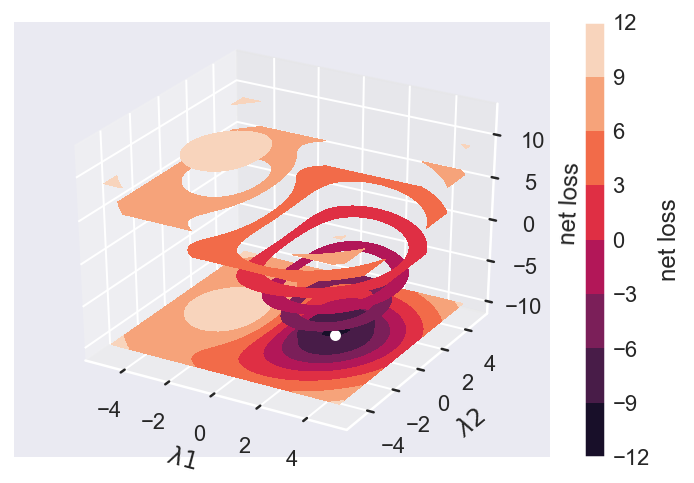

In [3]:
# plots 3D loss function with filled contour lines on function and
# projected into (lambda1, lambda2) plane
def plot_3D(ax, X, Y, Z, label=None):
    p1 = ax.contourf(X, Y, Z)
    p2 = ax.contourf(X, Y, Z, offset=np.min(Z)) # 2D projection
    
    ax.set_xlabel(r"$\lambda1$")
    ax.set_ylabel(r"$\lambda2$")
    ax.set_zlabel(label)
    
    cbar = plt.colorbar(p1, label=label)
    cbar.ax.tick_params(size=0)

    # plot and print minimum location(s) to verify
    result = np.where(Z == np.min(Z))
    coord_min = zip(result[0], result[1])
    print("Location(s) of minimum")
    print("---------------------------------------")
    for i, j in coord_min:
        loc_min = X[i, j], Y[i, j]
        Z_min = Z[i, j]
        print(f"(lambda1, lambda2)_min: {loc_min}")
        print(f"evaluated min: {Z_min}\n")
        ax.scatter(*loc_min, Z_min, color='w')
        
    return ax

# net loss function: L(x, y, lambda1, lambda2)
def net_loss_func(lam2, lam1, x=None, y=None):
    if x is not None and y is not None:
        term1 = 0.000045 * lam2**2 * y
        term2 = -0.000098 * lam1**2 * x
        C3 = 0.003926 * lam1 * x
        term3 = C3 * np.exp( (y**2 - x**2)*(lam1**2 + lam2**2) )
        return np.sum(term1 + term2 + term3)
    else:
        sys.exit("data not provided")

# load data
data = np.loadtxt("HW5_data.csv", delimiter=',')

# set up range of lambda values to iterate over
N_samp = 45 
lim = 5
lambda1 = np.linspace(-lim, lim, N_samp)
lambda2 = np.linspace(-lim, lim, N_samp)

# evaluate net loss function
# I feel like there's a better way to do this with np.mgrid
LOSS = np.zeros((len(lambda1), len(lambda2)))
for i, lam1 in enumerate(lambda1):
    for j, lam2 in enumerate(lambda2):
        LOSS[j, i] = net_loss_func(lam1, lam2, *data)

# plot net loss vs. (lambda1, lambda2)
N_samp *= 1j # convert to imaginary for mgrid
LAM1, LAM2 = np.mgrid[-lim:lim:N_samp, -lim:lim:N_samp]

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
plot_3D(ax, LAM1, LAM2, LOSS, label="net loss")
plt.show()

Visually, we see that there is a minimum (white point) near $(\lambda_1, \lambda_2) = (2.05384, 0)$.

#### 1.2 Gradient Descent 

The average $\left(\overline L\right)$ of the loss function 
$L = C_1\lambda_2^2 y + C_2\lambda_1^2 x + C_3\lambda_1 x e^{(y^2 - x^2)(\lambda_1^2 + \lambda_2^2)}$ over the region bounded by the data, 
$\Omega = \{ (x, y)\ |\ x_0 \le x \le x_N,\ y_0 \le y \le y_N \}$ for $N$ data points as $N \to \infty$ is,

\begin{align}
\overline L = \frac{\iint_\Omega L\text{ d}\Omega}
{\iint_\Omega\text{ d}\Omega}\quad,
\end{align}

where $C_1, C_2, C_3 = (0.000045, -0.000098, 0.003926)$. Subbing in the constraint $y^2 - x^2 = -0.1$, we have

\begin{align}
\overline L &= \frac{C_1\lambda_2^2\int_{x_0}^{x_N}\text{ d}x
\int_{y_0}^{y_N}y\text{ d}y 
+ C_2\lambda_1^2\int_{y_0}^{y_N}\text{ d}y
\int_{x_0}^{x_N}x\text{ d}x
+ C_3\lambda_1\int_{y_0}^{y_N}\text{ d}y
\int_{x_0}^{x_N}x e^{-0.1(\lambda_1^2 + \lambda_2^2)} \text{ d} x}
{(x_N - x_0)(y_N - y_0)} \\
&= \frac{C_1\lambda_2^2(x_N - x_0)(y_N^2 - y_0^2)
+ C_2\lambda_1^2(x_N^2 - x_0^2)(y_N - y_0)
+ C_3\lambda_1 e^{-0.1(\lambda_1^2 + \lambda_2^2)}(x_N^2 - x_0^2)(y_N - y_0)}
{2(x_N - x_0)(y_N - y_0)} \\
&= \frac{1}{2}\left[ 
C_1\lambda_2^2(y_N + y_0) 
+ C_2\lambda_1^2(x_N + x_0)
+ C_3\lambda_1 e^{-0.1(\lambda_1^2 + \lambda_2^2)}(x_N + x_0)
\right] \quad.
\end{align}

We can plot this function to double check that it is similar to the original function summed over the data.

Location(s) of minimum
---------------------------------------
(lambda1, lambda2)_min: (2.045454545454545, 0.0)
evaluated min: -0.09510191829297235



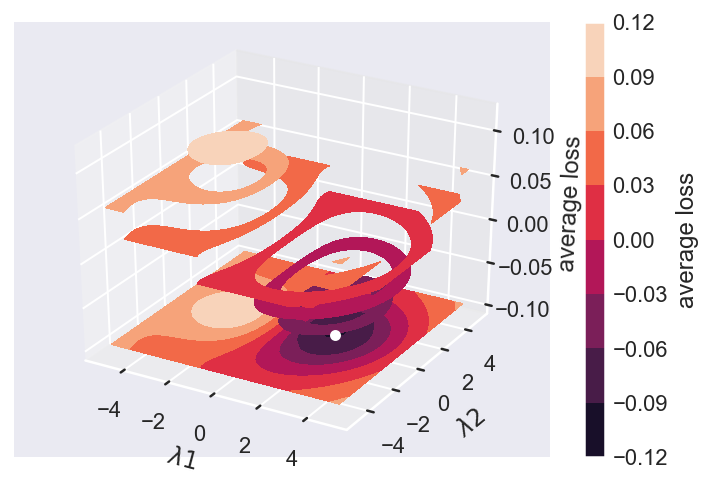

In [4]:
# loss function averaged over the data
def loss_func_avg(LAM1, LAM2, x=None, y=None):
    if x is not None and y is not None:
        C1, C2, C3 = 0.000045, -0.000098, 0.003926
        x_sum, y_sum = x[-1] + x[0], y[-1] + y[0]
        LAM1_sq, LAM2_sq = LAM1**2, LAM2**2
        LAM_sum = LAM1_sq + LAM2_sq
        term1 = C1 * LAM2_sq * y_sum
        term2 = C2 * LAM1_sq * x_sum
        term3 = C3 * LAM1 * np.exp(-0.1*LAM_sum) * x_sum
        return 0.5*(term1 + term2 + term3)
    else:
        sys.exit("please enter data")

# evaluate function
data = np.loadtxt("HW5_data.csv", delimiter=',')
N_lam = 45j # number of points in each lambda direction
lim = 5
LAM1, LAM2 = np.mgrid[-lim:lim:N_lam, -lim:lim:N_lam]
LOSS = loss_func_avg(LAM1, LAM2, *data)

# display
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
plot_3D(ax, LAM1, LAM2, LOSS, label="average loss")
plt.show()

We get the same result! 

Ok, we want to do gradient descent on this averaged function, so let's start taking some partials:

\begin{align}
\frac{\partial\overline L}{\partial \lambda_1}
&= \frac{1}{2}
\left[
2 C_2 \lambda_1 (x_N + x_0) 
+ C_3 e^{-0.1(\lambda_1^2 + \lambda_2^2)}(1 - 0.2\lambda_1^2)(x_N + x_0)
\right] 
\quad\\
\frac{\partial\overline L}{\partial \lambda_2}
&= \frac{1}{2}\left[
2 C_1\lambda_2(y_N + y_0)
- 0.2 C_3\lambda_1\lambda_2 e^{-0.1(\lambda_1^2 + \lambda_2^2)}(x_N + x_0)
\right] \quad.
\end{align}

Awesome. Now we know which way is downhill. If we are standing on a hill given by a function $f$ at the location $\pmb x$ projected on the dimension below, and want to take a step $l_r$ down the steepest part, we would be at the new height

\begin{align}
f(\pmb x_i) = f(\pmb x_{i-1}) - l_r\nabla f(\pmb x_{i-1}) \quad,
\end{align}

where $l_r$ is also known as the learning rate, $i$ is the step we went to and $i-1$ is the step we were at. Continuing the process until we are within 1e-3 of the ground truth $(\lambda_1, \lambda_2)_\text{truth} = (2.05384, 0)$ then gives us the following results for our gradient descent:

GD converged after 308 steps
GD input parameters
-------------------
init: [2 1]
grad: <function grad_net_avg at 0x1c1a7ddb00>
data: [[ 17.21886188  20.83899915  11.96843043 ... -97.91610676 -49.3888998
  -56.23604129]
 [-17.21595784  20.83659966  11.96425205 ... -97.91559612  49.38788741
   56.23515217]]
lr: 1.0
truth: [2.05384 0.     ]
tol: 0.001
N: 1000000.0
max_iters: 10000.0
show_stats: True

sim took 0.17395900000005682 ms
average iteration time (ms): 0.012257841423958792
final result: (lambda1, lambda2) = [2.05384883e+00 9.84862226e-04]


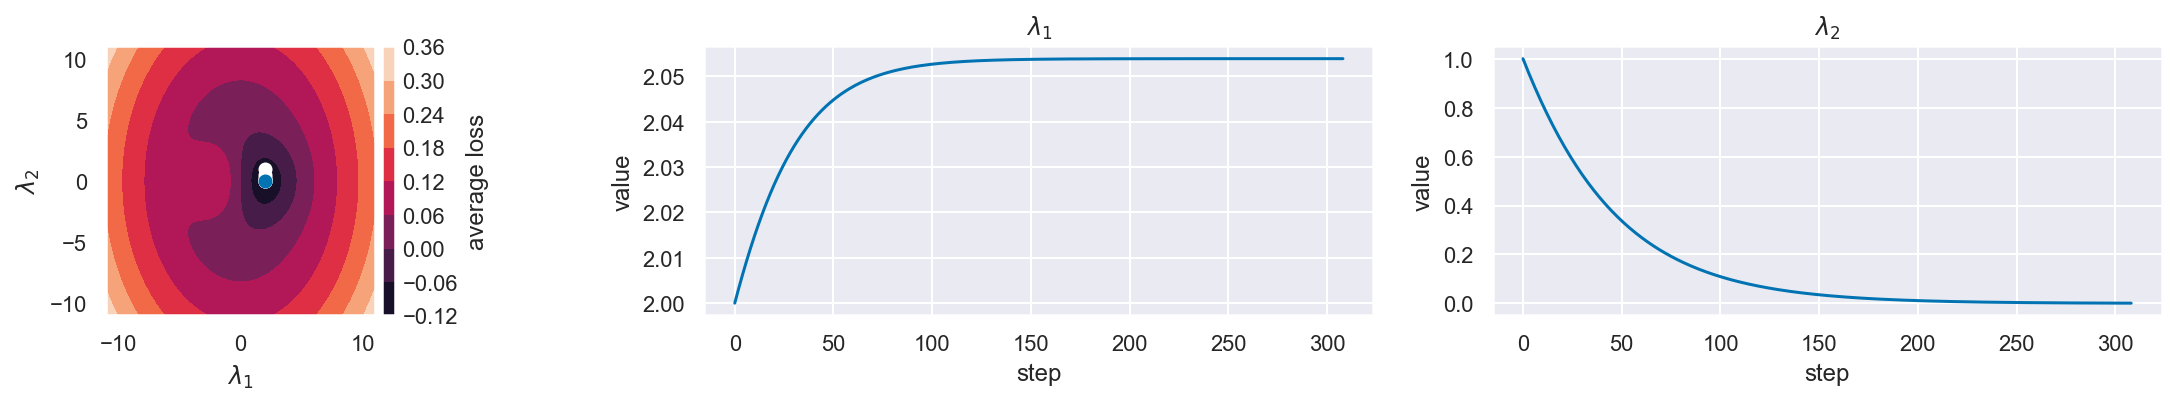

In [5]:
# gradient of loss function averaged over the data
def grad_net_avg(lam1, lam2, x=None, y=None):
    C1, C2, C3 = 0.000045, -0.000098, 0.003926
    x_sum, y_sum = x[-1] + x[0], y[-1] + y[0]
    lam_sum = lam1**2 + lam2**2
    lam_exp = np.exp( -0.1 * (lam_sum) )
    
    p1 = 2.* C2 * lam1 * x_sum
    p2 = C3 * lam_exp * (1. - 0.2*lam1**2) * x_sum 
    partial_lam1 = 0.5*(p1 + p2)
    
    p1 = 2. * C1 * lam2 * y_sum
    p2 = -0.2 * C3 * lam1 * lam2 * lam_exp * x_sum
    partial_lam2 = 0.5*(p1 + p2)
    
    return np.array([partial_lam1, partial_lam2])


# 2D gradient descent algorithm
def GD(init=_, grad=_, data=_, lr=_, truth=_, tol=_, N=_, max_iters=_,
       show_stats=_):
    input_params = locals()
    N = int(N) # convert sci-notation to int
    times = np.empty(N)
    sols = np.empty((N, 2))
    sols[0, :] = init
    #sols = []
    #sols.append(init)
    for i in range(1, N):
        start = time.perf_counter()
        sols[i, :] = sols[i-1, :] - lr * grad(*sols[i-1, :], *data)
        #sols.append(sols[i-1] - lr * grad(*sols[i-1], *data))
        end = time.perf_counter() - start
        times[i] = end
        diff = np.sqrt(np.sum((sols[i, :] - truth)**2)) # norm distance
        #diff = np.sqrt((sols[i][0] - truth[0])**2 + sols[i][1] - truth[1]**2) # norm distance
        if diff <= tol:
            print(f"GD converged after {i} steps")
            break
        if i >= max_iters:
            print(f"GD did not converge after {i} steps")
            break
            
    if show_stats:
        print("GD input parameters")
        print("-------------------")
        for k, v in input_params.items():
            print(f"{k}: {v}")
        print()
    return sols[:i+1, :], times[:i+1]
    #return sols, times

# plots the following: 
# i)   path of gradient descent in (lambda1, lambda2) space
# ii)  path of lambda1 (x) each step
# iii) path of lambda2 (y) each step
def plot_descent(params, init, param_func, data=None, N_param=100, label=None):
    fig, axes = plt.subplots(1, 3, figsize=(16, 3))
    
    # lambda1, lambda2 gradient descent walk
    x, y = params.T
    # select 10 evenly spaced points for visualization 
    idx_samp = np.round(np.linspace(0, len(params) - 1, 10)).astype(int)
    x_samp, y_samp = x[idx_samp[:-1]], y[idx_samp[:-1]]
    lim = 11 #1.5*np.nanmax(np.abs(params)) # plot-window limits
    N_param = N_param * 1j # number of points to sample along each param
    X, Y = np.mgrid[-lim:lim:N_param, -lim:lim:N_param]
    Z = param_func(X, Y, *data) 
    divider = make_axes_locatable(axes[0])
    p1 = axes[0].contourf(X, Y, Z)
    axes[0].plot(x, y, "w")
    axes[0].plot(x_samp, y_samp, "wo") # trail
    axes[0].plot(x[-1], y[-1], "bo") # endpoit
    axes[0].set_aspect("equal")
    axes[0].set_xlabel(r"$\lambda_1$")
    axes[0].set_ylabel(r"$\lambda_2$")
    axes[0].set_xlim(-lim, lim)
    axes[0].set_ylim(-lim, lim)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(p1, ax=axes[0], cax=cax, label=label)
    cbar.ax.tick_params(size=0)

    # lambda1 walk
    axes[1].plot(params[:, 0])
    axes[1].set_xlabel("step")
    axes[1].set_ylabel("value")
    axes[1].set_title(r"$\lambda_1$")

    # lambda2 walk
    axes[2].plot(params[:, 1])
    axes[2].set_xlabel("step")
    axes[2].set_ylabel("value")
    axes[2].set_title(r"$\lambda_2$")

    fig.tight_layout()
    plt.show()
    
# run gradient descent
data = np.loadtxt("HW5_data.csv", delimiter=',')
GD_params = {
    "lr": 1., # learning rate,
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "max_iters": 1e4, # GD terminates if this limit is met
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "init": np.array([2, 1]), # starting location
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats": True, # print out ingredients?
}
lambdas_GD, times_GD = GD(**GD_params)
start = time.perf_counter()
lambdas_GD = np.array(lambdas_GD).reshape(len(lambdas_GD), 2)
end = time.perf_counter() - start
print(f"sim took {end * 1e3} ms")
print(f"average iteration time (ms): {np.mean(times_GD * 1e3)}")
#print(f"(lambda1, lambda2): {lambdas_GD[-1, :]}")
print(f"final result: (lambda1, lambda2) = {lambdas_GD[-1]}")

# display results
plot_descent(lambdas_GD, GD_params["init"], loss_func_avg, data, 
             label="average loss")

The algorithm converged within a couple hundred steps! We can see each parameters flattening out in the right two plots as the steps reach the minimum of the averaged function. This is also shown by the white points in the left plot approaching the minimum (dark) region. The convergence condition could have also been done by terminating after the current step was within something like machine precision of the previous step.

#### 1.3 Stochastic Gradient Descent

SGD with a batch size of 1 is very similar to GD, with the only difference being what is used to determine the gradient. With Gradient Descent, it was based on the entire dataset, and really only the first and last data point in the dataset when looking at the averaged loss function. With Stochastic Gradient Descent, the dataset is reduced to a random subset, with a size given by the mini-batch size. After taking a step based on this mini-batch, a new batch is chosen and the process repeated. The implementation for this is shown below. To save on overhead with the random selection process, the entire dataset is shuffled ahead of time, and then a sliding window as wide as the batch size passes over the shuffled data without repeating values. The results are shown below:

SGD converged after 3411 total steps within 1 epoch(s)
SGD input parameters
--------------------
init: [2 1]
grad: <function grad_net_avg at 0x1c1a7ddb00>
data: [[-30.55428682 -41.23387487 -90.07525289 ... -63.37012855 -41.72199209
  -72.72098754]
 [-30.55265035  41.23266226  90.0746978  ...  63.36933953  41.72079366
   72.72029998]]
lr: 1.0
bs: 1
truth: [2.05384 0.     ]
tol: 0.001
N: 1000000.0
max_epochs: 10
show_stats: True

average iteration time: 0.011338479050683721
final result: (lambda1, lambda2) = [2.05384891e+00 9.79710837e-04]


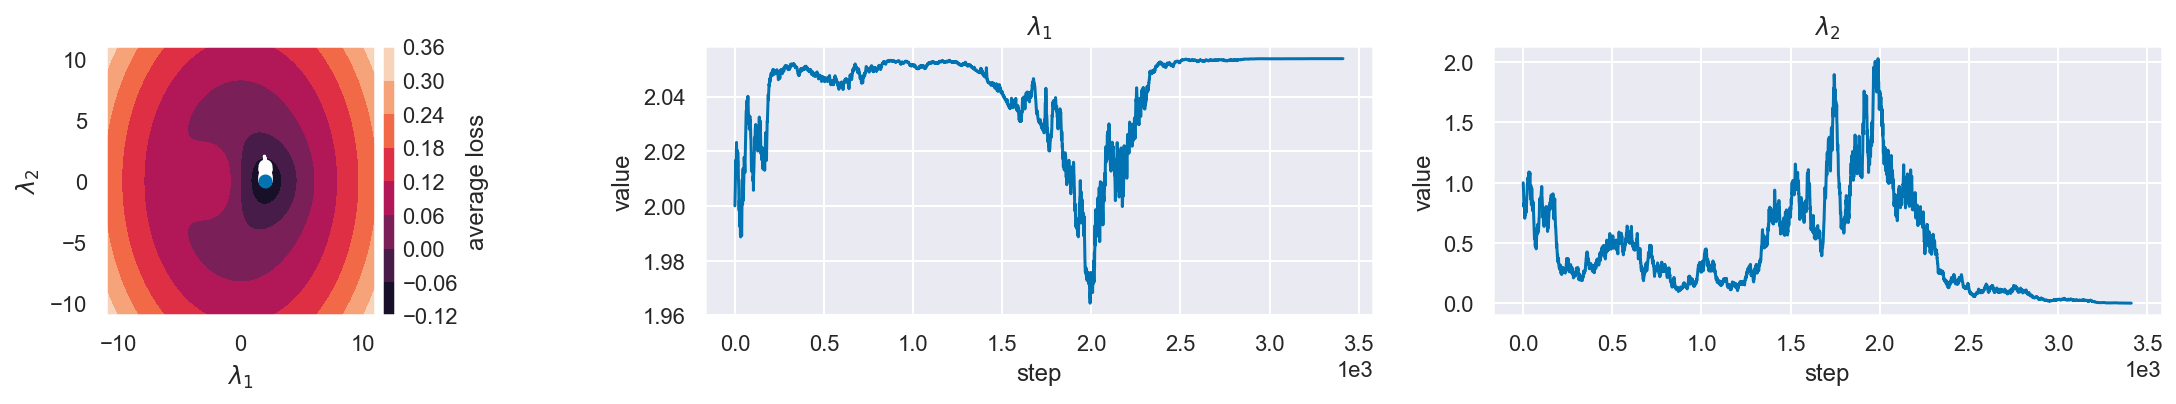

sim + plot took 1014.8615000000003 ms


In [6]:
# 2D stochastic gradient descent algorithm
def SGD(init=_, grad=_, data=_, lr=_, bs=_, truth=_, tol=_, N=_,
        max_epochs=_, show_stats=_):
    data = np.copy(data)
    np.random.shuffle(data.T) # leave original data untouched
    input_params = locals()
    N = int(N) # convert sci-notation to int
    batch_idx = 0
    E_count = 1
    times = np.zeros(N)
    sols = np.zeros((N, 2))
    sols[0, :] = init
    for i in range(1, N):
        if batch_idx > (len(data.T) - bs):
            np.random.shuffle(data)
            batch_idx = 0
            E_count += 1
        data_rand = data[:, batch_idx:batch_idx+bs].reshape(2, bs)
        batch_idx += bs
        start = time.perf_counter()
        sols[i, :] = sols[i-1, :] - lr * grad(*sols[i-1, :], *data_rand)
        times[i] = time.perf_counter() - start
        diff = np.sqrt(np.sum((sols[i, :] - truth)**2)) # norm distance
        if diff <= tol:
            print(f"SGD converged after {i-1} total steps within {E_count} epoch(s)")
            break
        if E_count > max_epochs:
            print(f"SGD did not converge after {i-1} total steps within {E_count-1} epoch(s)")
            break
            
    if show_stats:
        print("SGD input parameters")
        print("--------------------")
        for k, v in input_params.items():
            print(f"{k}: {v}")
        print()
    return sols[:i+1, :], times[:i+1]

# run stochastic gradient descent
data = np.loadtxt("HW5_data.csv", delimiter=',')
SGD_params = {
    "lr": 1., # learning rate,
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "init": np.array([2, 1]), # starting location
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats": True, # print out ingredients?
    "bs": 1,
    "max_epochs": 10,
}
start = time.perf_counter()
lambdas_SGD, times_SGD = SGD(**SGD_params)
#print(f"(lambda1, lambda2): {lambdas_GD[-1, :]}")
print(f"average iteration time: {np.mean(times_SGD * 1e3)}")
print(f"final result: (lambda1, lambda2) = {lambdas_SGD[-1]}")

# display results
plot_descent(lambdas_SGD, SGD_params["init"], loss_func_avg, data, 
             label="average loss")
end = time.perf_counter() - start
print(f"sim + plot took {end * 1e3} ms")

SGD converged under the same 1e-3 criteria and initial conditions as GD in 1.2, but it took significantly more steps!

#### 1.4 How to Compare GD and SGD Fairly

Averaging the loss function over the data is similar to computing the net loss function because they both involve summing $(\lambda_1, \lambda_2)$ over the data. The average loss function is then just the net loss function divided by a constant pretty much, which does not affect the location of the global minimum.

#### 1.5 Comparing the Efficiency of GD and SGD

The time taken to complete each iteration was saved above. Looking at this and the total number of steps taken to converge with each scheme is shown below:

GD
average time (ms):0.012257841423958792
N_converge: 309

SGD
average time (ms):0.011338479050683721
N_converge: 3413



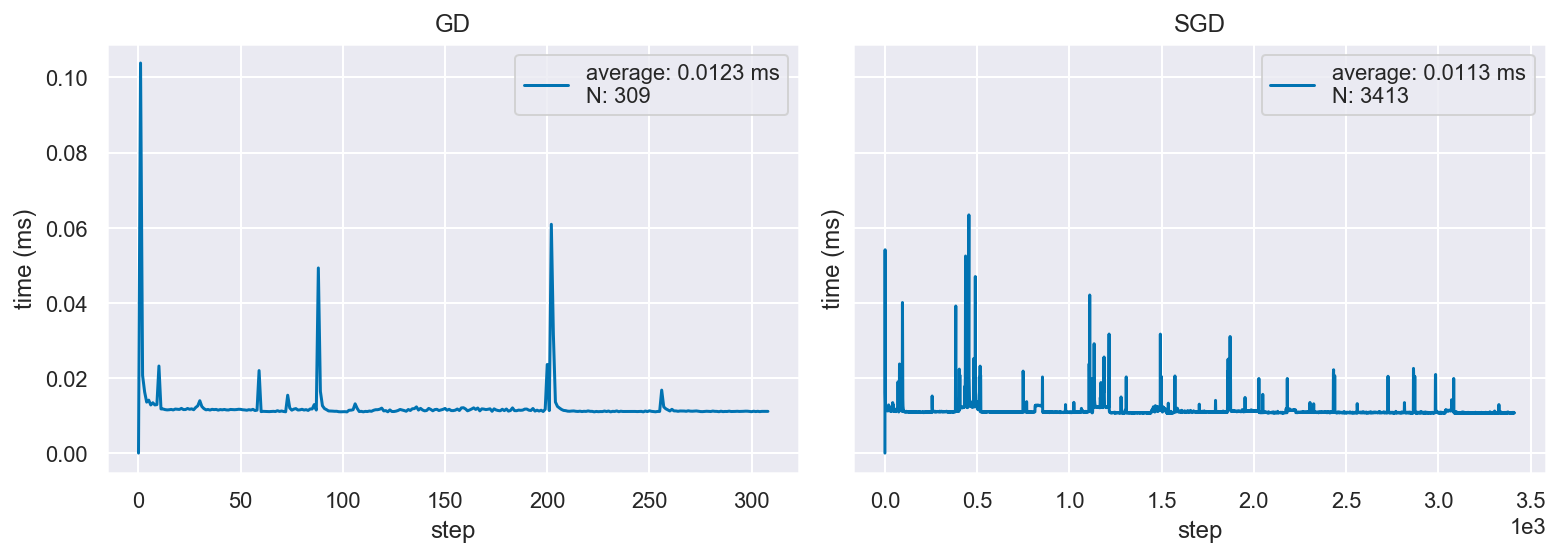

In [7]:
fig, axes = plt.subplots(1, 2, figsize=fig_wide, sharey=True)

sim_data = (
    ("GD", times_GD, lambdas_GD), 
    ("SGD", times_SGD, lambdas_SGD),
)

for ax, sd in zip(axes, sim_data):
    t = sd[1] * 1e3 # convert to milliseconds
    t_mean = np.mean(t)
    N_converge = len(sd[2])
    print(f"{sd[0]}\naverage time (ms):{t_mean}\nN_converge: {N_converge}\n")
    ax.plot(t, label=f"average: {t_mean:.4f} ms\nN: {N_converge}")
    ax.set_ylabel("time (ms)")
    ax.set_title(sd[0])
    ax.legend(loc=1)
    ax.set_xlabel("step")

fig.tight_layout()

It took about an order of magnitude more steps for the SGD implementation to converge, but interestingly the average time to complete each iteration is roughly the same. Intuitively, it makes sense that GD converges faster than SGD because it consistently follows the gradient of the landscape down towards the global minimum while SGD follows a gradient that is randomly determined each iteration. SGD has the benefit of avoiding getting stuck in possible local minima when converging towards the global minimum. As we saw in the visualization of the optimization landscape in 1.1 though, we only have a single global minimum, so SGD does not buy us anything in this particular case.

If we were trying to minimize the net loss function or averaged the loss function using all of the data instead, SGD would be faster because it only uses a subset of the data, making computation for the next step faster.

#### 1.6 Comparing Sensitivity of GD and SGD to Learning Rate

Now let's play with the learning rate. The results for `lr = [1000, 100, 1, 0.1]` are shown below for GD and SGD.

GD results
----------
GD did not converge after 100000 steps
learning rate: 1000
average iteration time (ms): 0.012
total number of steps: 100001
(lambda1, lambda2): [nan nan]


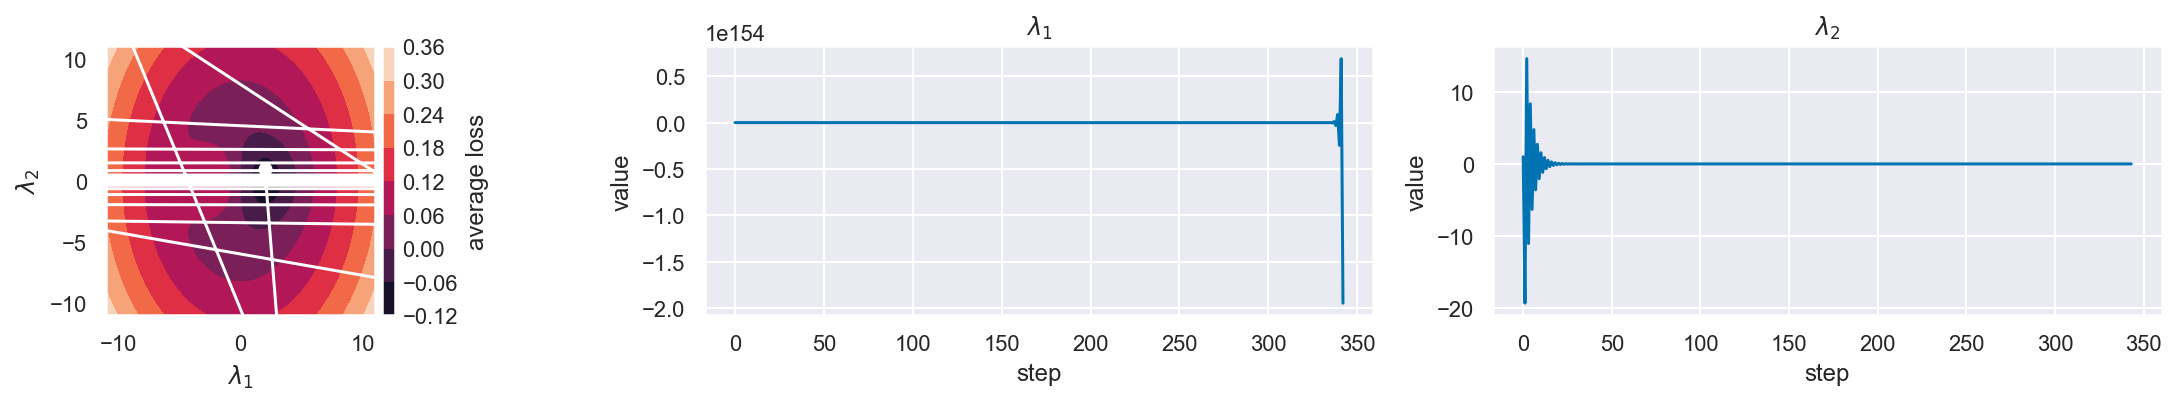


GD converged after 6142 steps
learning rate: 100
average iteration time (ms): 0.014
total number of steps: 6143
(lambda1, lambda2): [2.05286757e+000 1.12646967e-321]


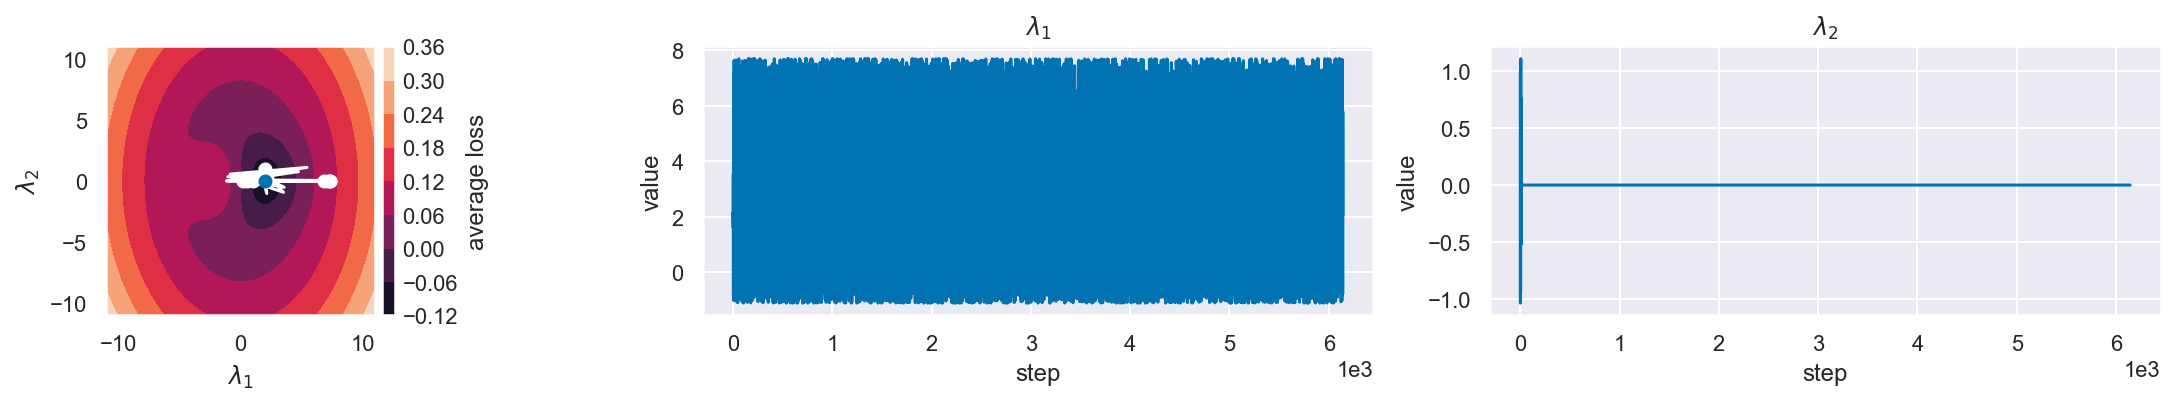


GD converged after 308 steps
learning rate: 1.0
average iteration time (ms): 0.014
total number of steps: 309
(lambda1, lambda2): [2.05384883e+00 9.84862226e-04]


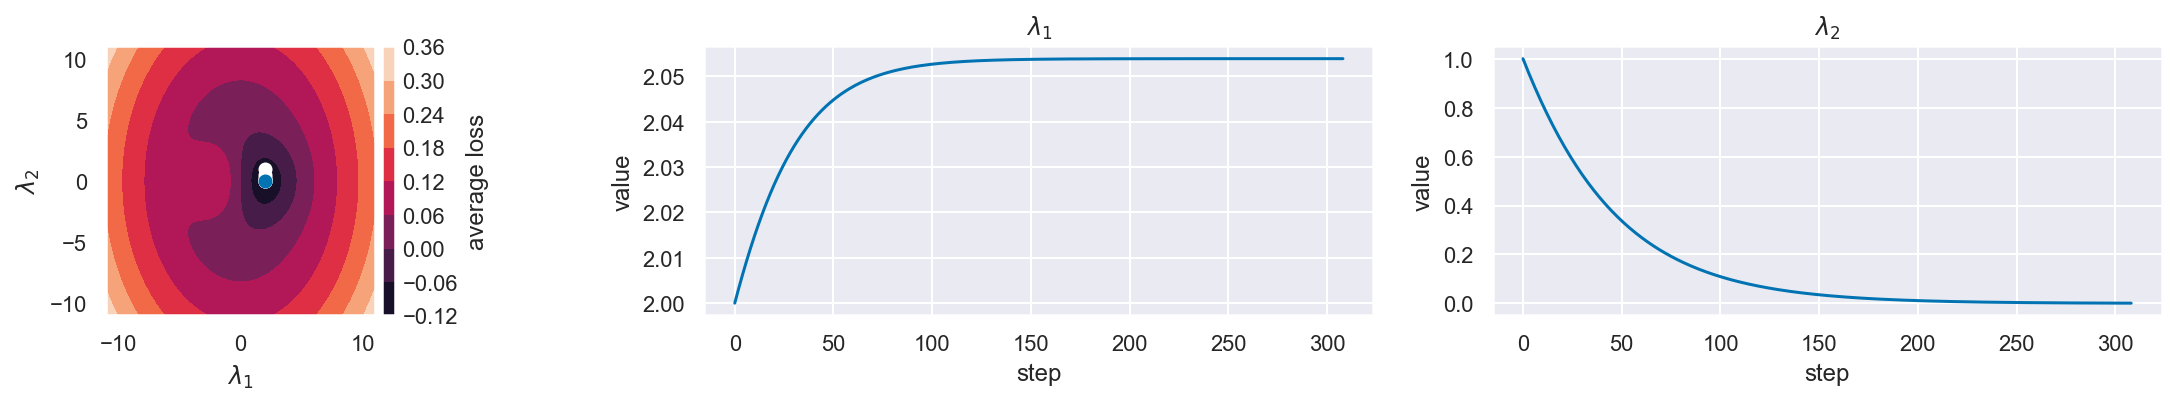


GD converged after 3105 steps
learning rate: 0.1
average iteration time (ms): 0.014
total number of steps: 3106
(lambda1, lambda2): [2.05384882e+00 9.97851086e-04]


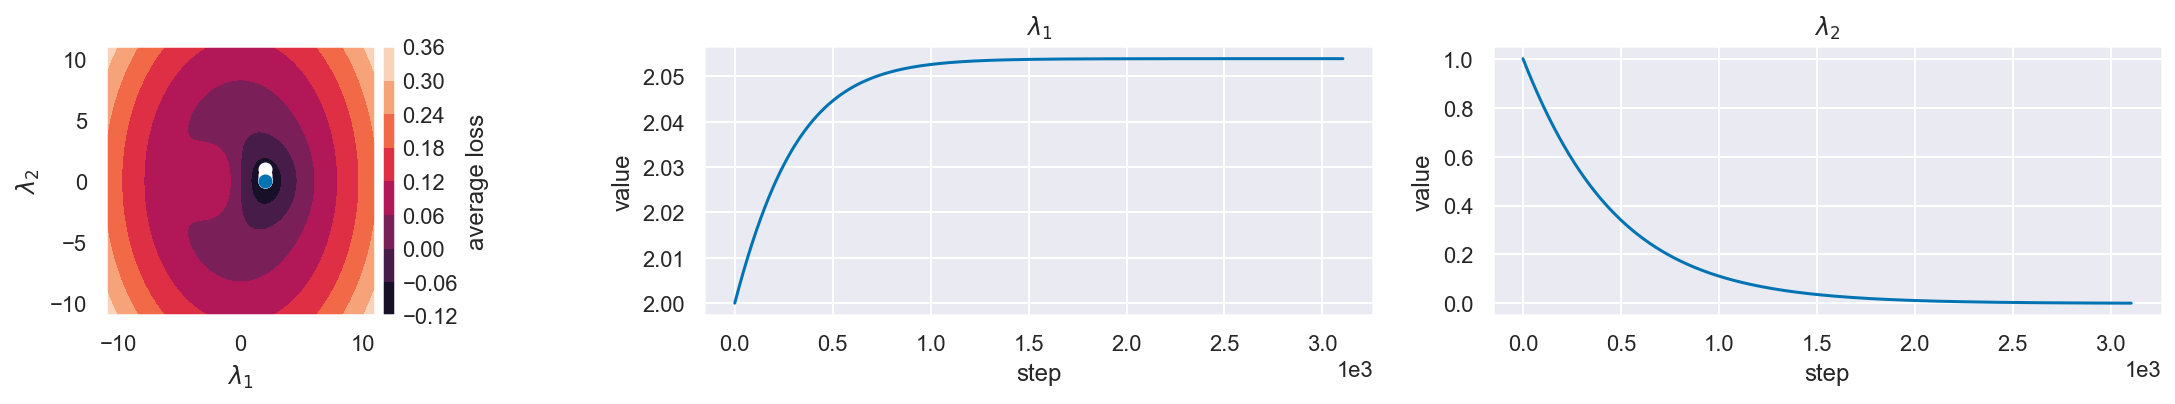


SGD results
-----------
SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 1000
average iteration time (ms): 0.012
total number of steps: 160002
(lambda1, lambda2): [nan nan]


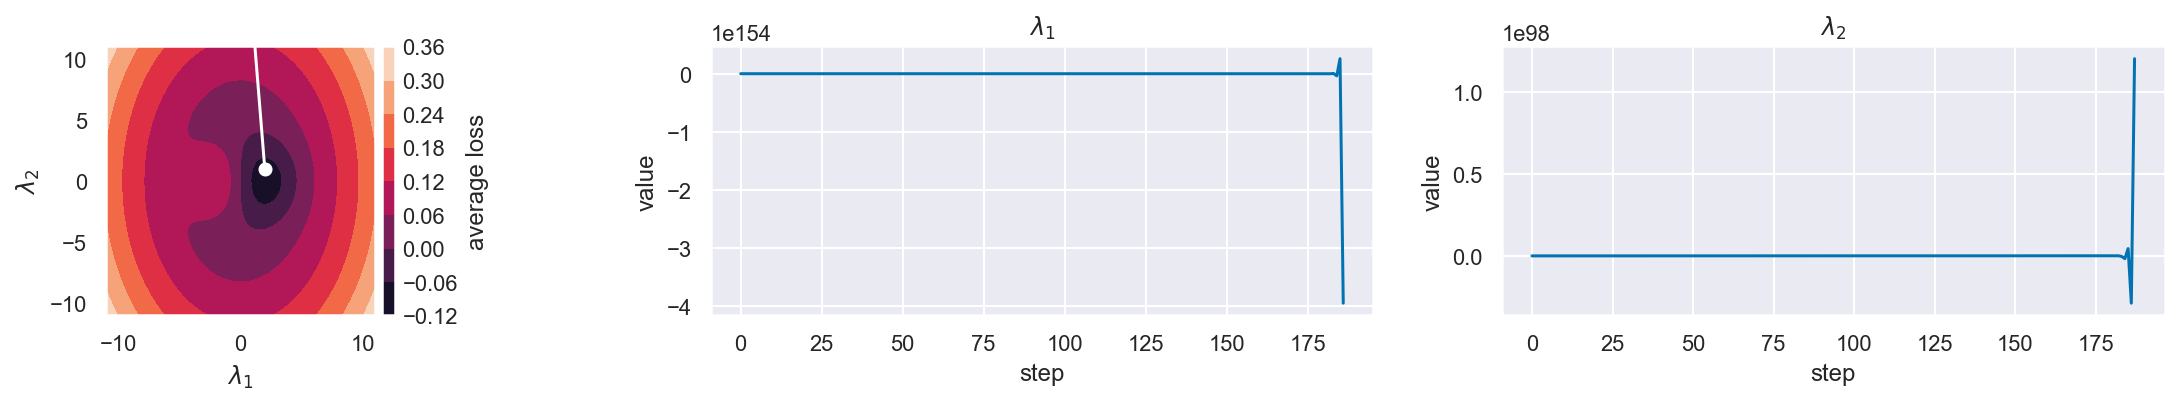


SGD converged after 14998 total steps within 1 epoch(s)
learning rate: 100
average iteration time (ms): 0.013
total number of steps: 15000
(lambda1, lambda2): [ 2.05449274e+000 -1.78584899e-200]


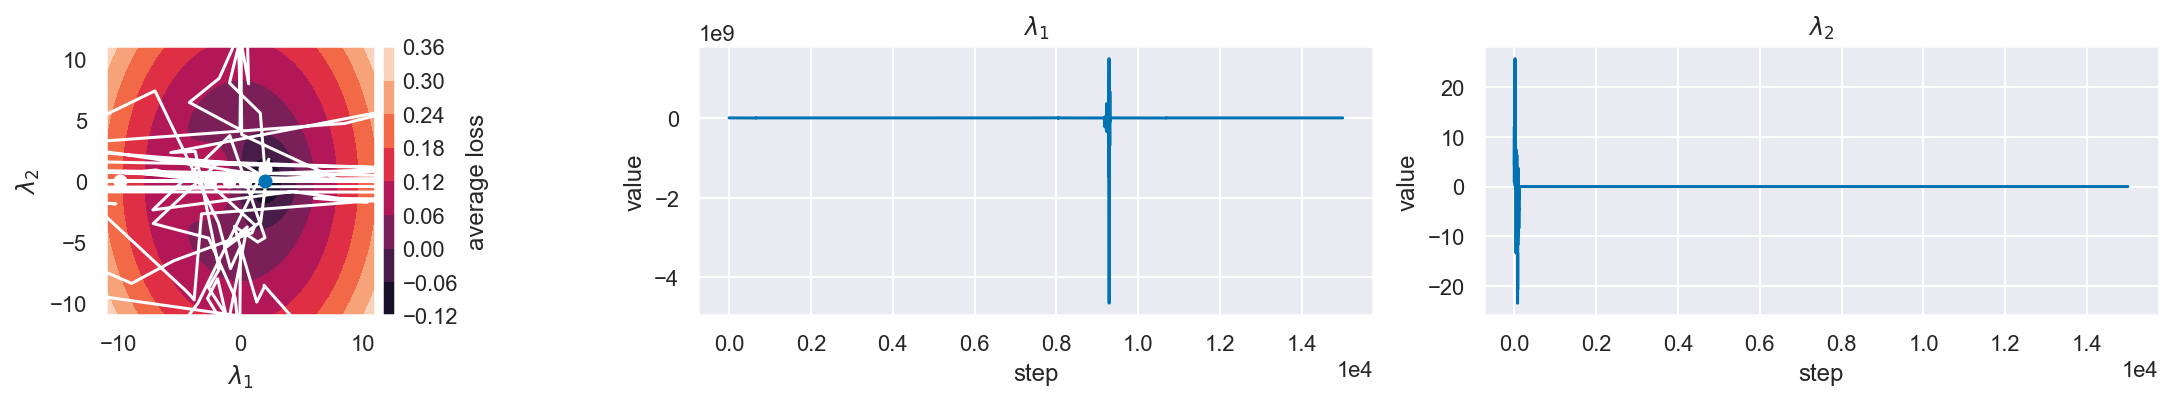


SGD converged after 1313 total steps within 1 epoch(s)
learning rate: 1.0
average iteration time (ms): 0.012
total number of steps: 1315
(lambda1, lambda2): [2.05384892e+00 9.75196653e-04]


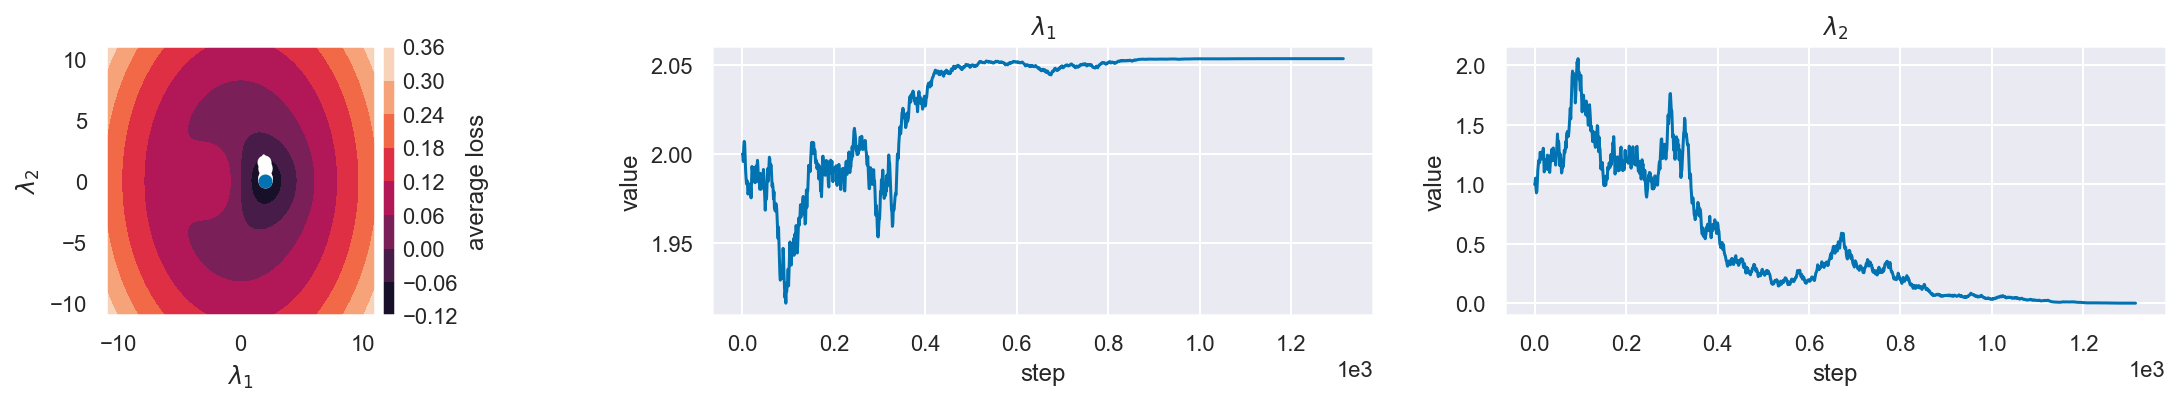


SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 0.1
average iteration time (ms): 0.011
total number of steps: 160002
(lambda1, lambda2): [1.82476896 2.30801791]


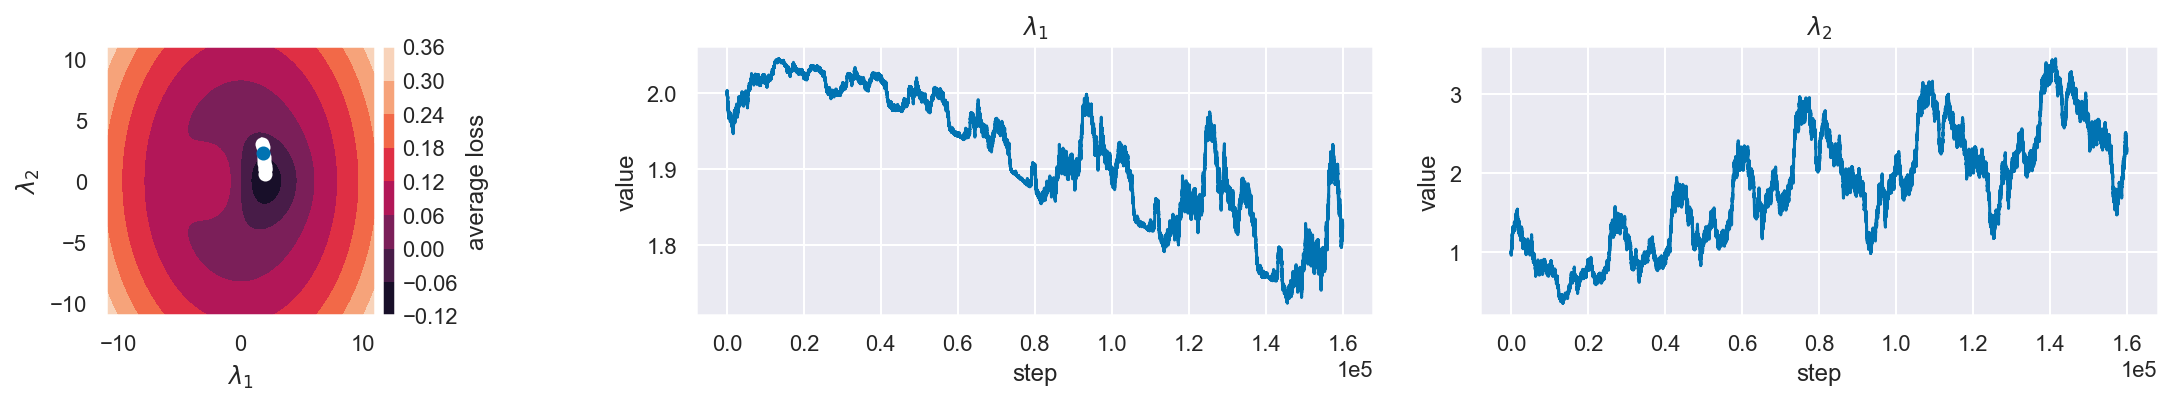

In [8]:
data = np.loadtxt("HW5_data.csv", delimiter=',')
GD_params = {
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "max_iters": 1e5, # GD terminates if this limit is met
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "init": np.array([2, 1]), # starting location
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats":False
}
SGD_params = {
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "max_epochs": 10, # GD terminates if this limit is met
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "init": np.array([2, 1]), # starting location
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats": False,
    "bs": 1, # batch size
}

learning_rates = [1000, 100, 1., 0.1]

print("GD results")
print("----------")
for lr in learning_rates:
    lambdas_GD, times_GD = GD(**GD_params, lr=lr)
    t_avg, N = np.mean(times_GD * 1e3), len(lambdas_GD)
    print(f"learning rate: {lr}")
    print(f"average iteration time (ms): {t_avg:.3f}")
    print(f"total number of steps: {N}")
    print(f"(lambda1, lambda2): {lambdas_GD[-1, :]}")
    plot_descent(lambdas_GD, GD_params["init"], 
             loss_func_avg, data, label="average loss")
    print()

print("SGD results")
print("-----------")
for lr in learning_rates:
    lambdas_SGD, times_SGD = SGD(**SGD_params, lr=lr)
    t_avg, N = np.mean(times_SGD * 1e3), len(lambdas_SGD)
    print(f"learning rate: {lr}")
    print(f"average iteration time (ms): {t_avg:.3f}")
    print(f"total number of steps: {N}")
    print(f"(lambda1, lambda2): {lambdas_SGD[-1, :]}")
    plot_descent(lambdas_SGD, SGD_params["init"], 
             loss_func_avg, data, label="average loss")
    print()

We see that there is a sweet spot for the learning rate. Too large and we have no chance of converging as we overshoot the minimum. Too small and it takes forever to get there. SGD also happens to perform a bit better with larger learning rate because it has the added benefit of stochasticity potentially putting us back on track if we overshoot.

#### 1.7 Comparing Sensitivity of GD and SGD to Initialization 

Doing the same thing for the same range of learning rates, but at different starting points now produces the following results:

GD results
----------
GD did not converge after 100000 steps
learning rate: 10.0
starting location: (-2.47865, 0)
average iteration time (ms): 0.011
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


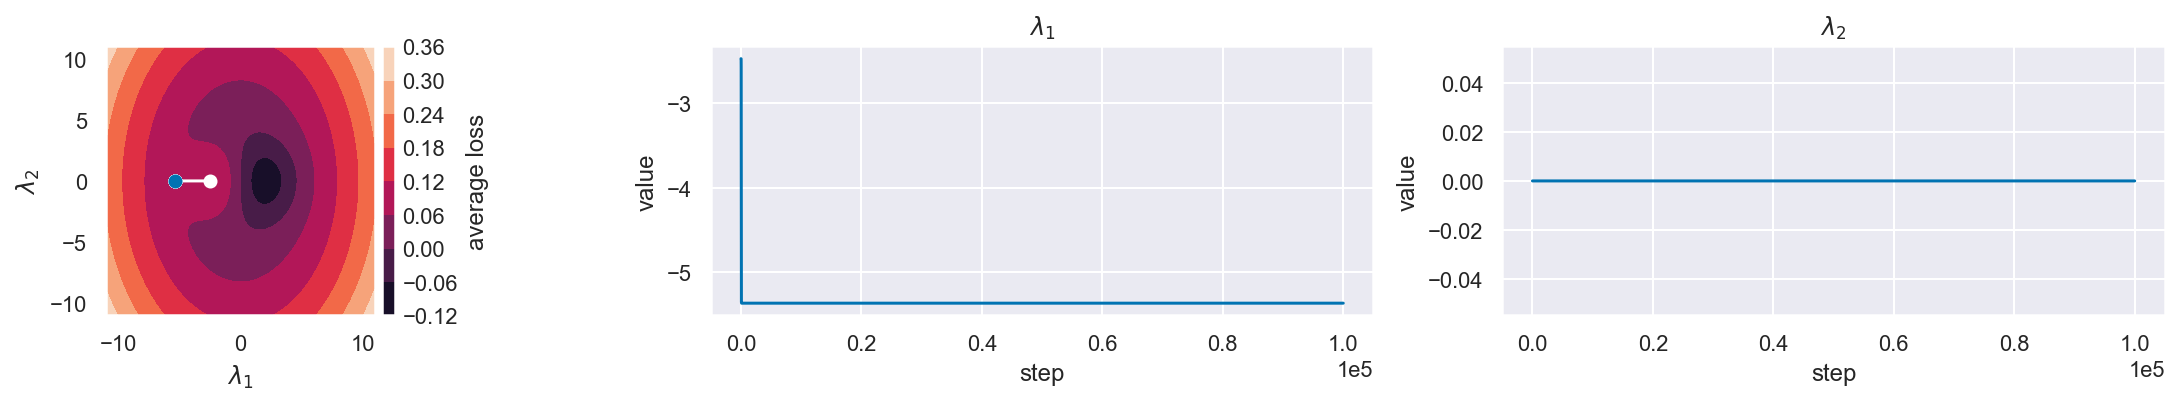


GD did not converge after 100000 steps
learning rate: 10.0
starting location: (-3, 0)
average iteration time (ms): 0.011
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


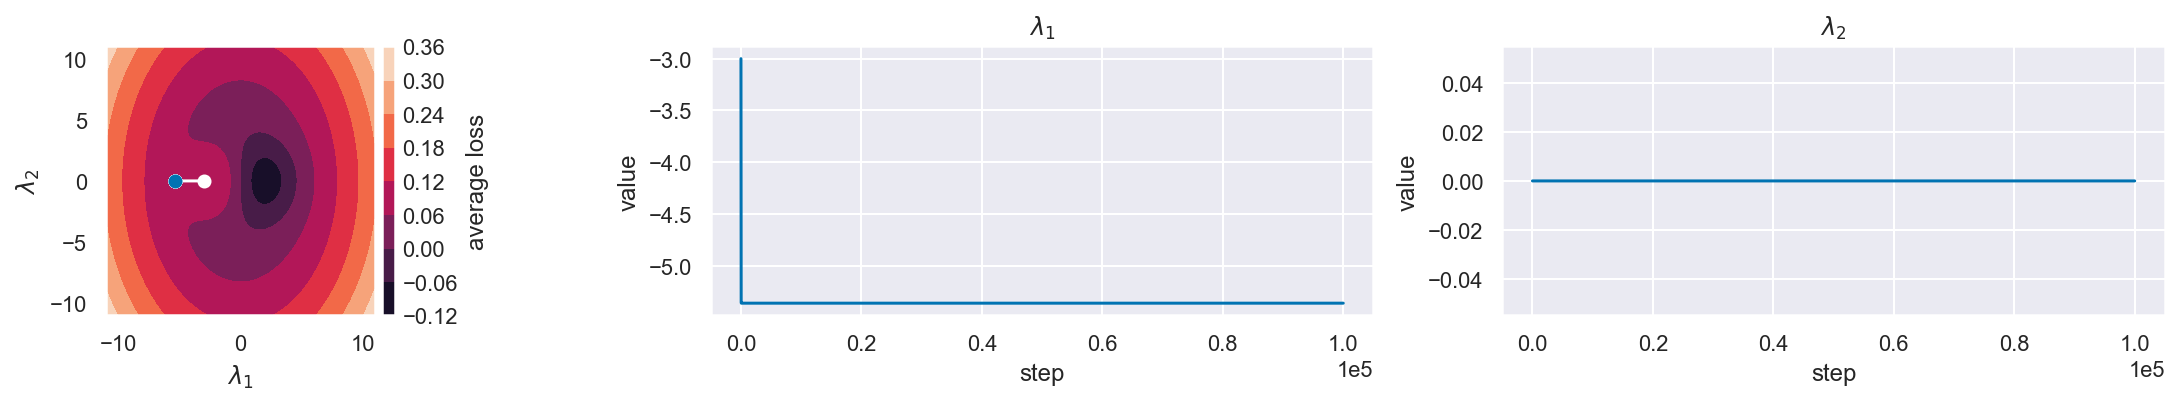


GD did not converge after 100000 steps
learning rate: 10.0
starting location: (-5, 0)
average iteration time (ms): 0.011
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


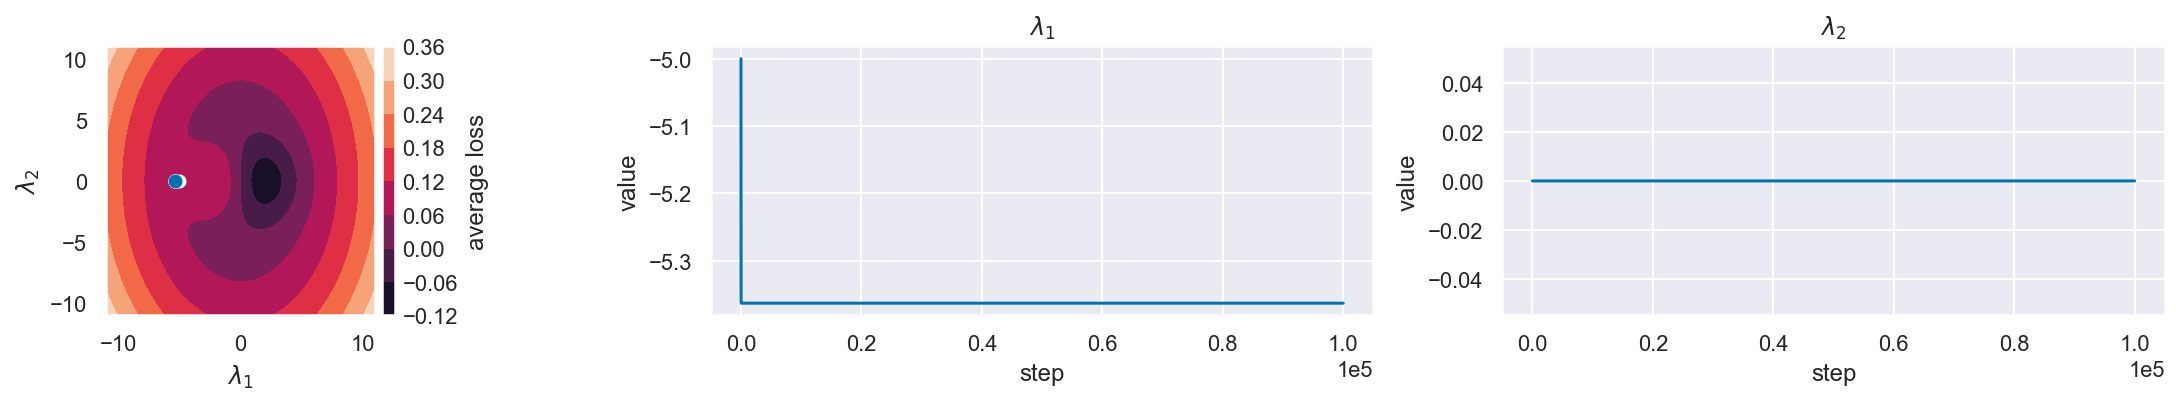


GD did not converge after 100000 steps
learning rate: 10.0
starting location: (-10, 0)
average iteration time (ms): 0.011
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


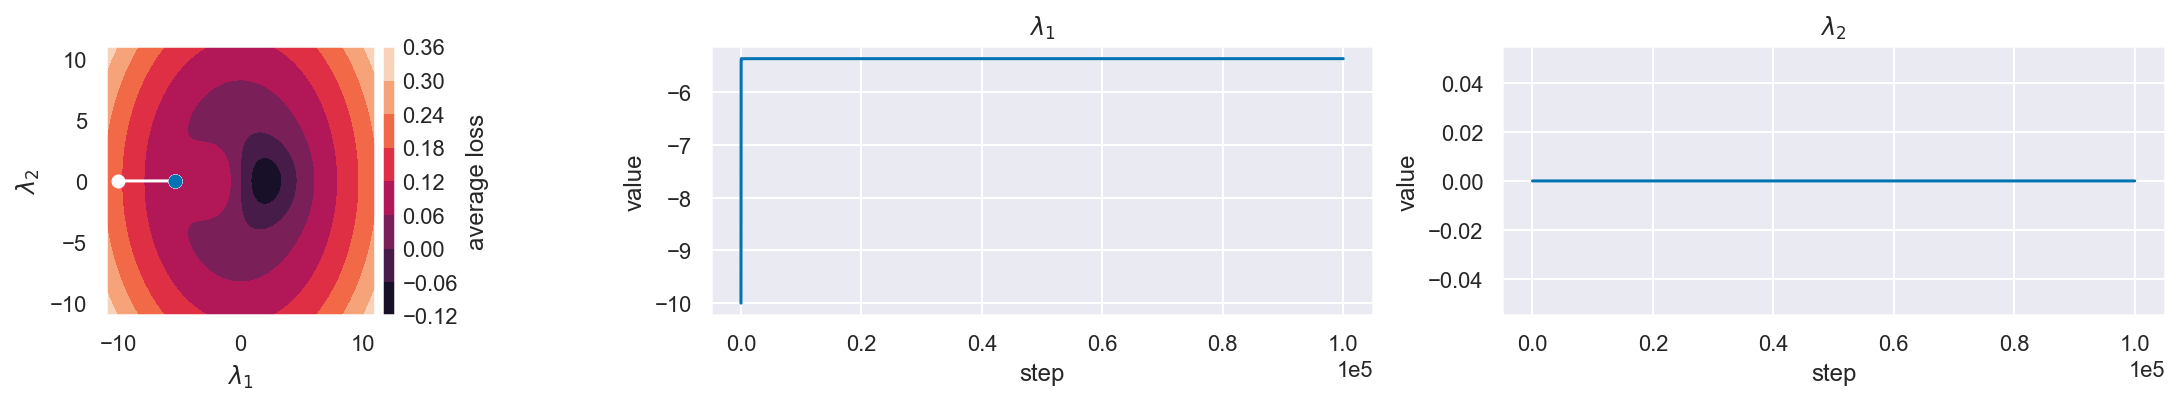


GD did not converge after 100000 steps
learning rate: 50.0
starting location: (-2.47865, 0)
average iteration time (ms): -0.038
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


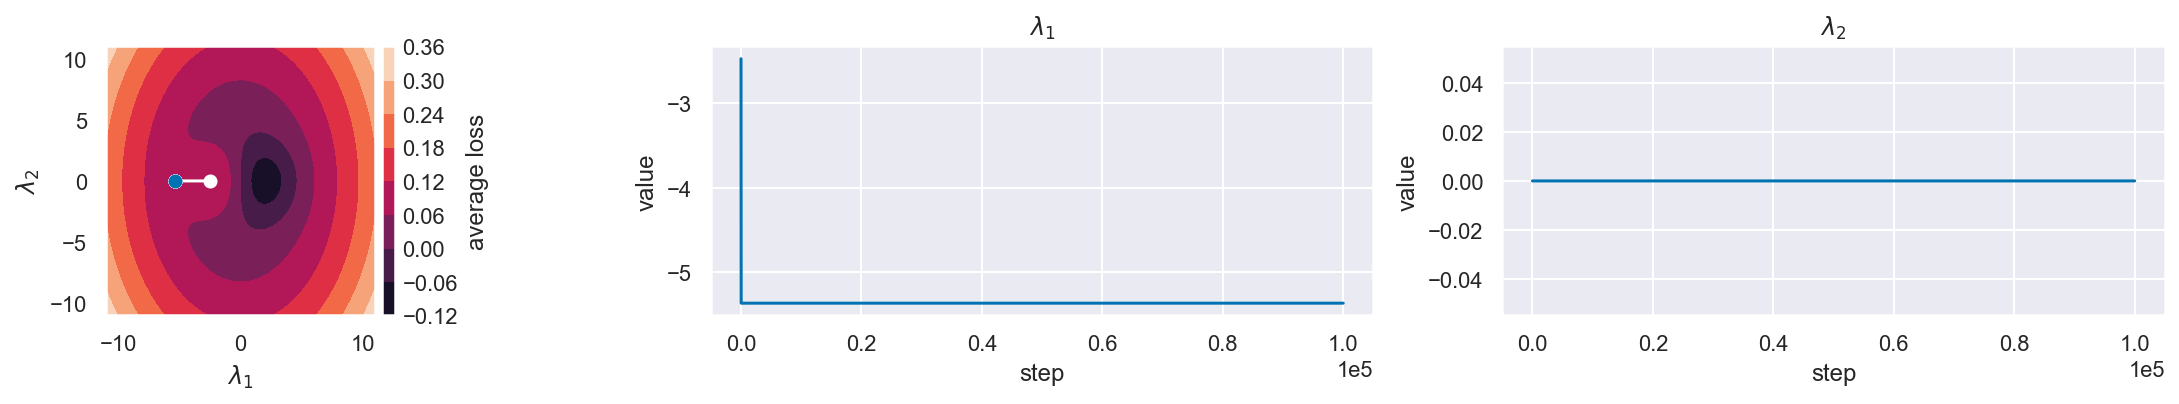


GD did not converge after 100000 steps
learning rate: 50.0
starting location: (-3, 0)
average iteration time (ms): 0.012
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


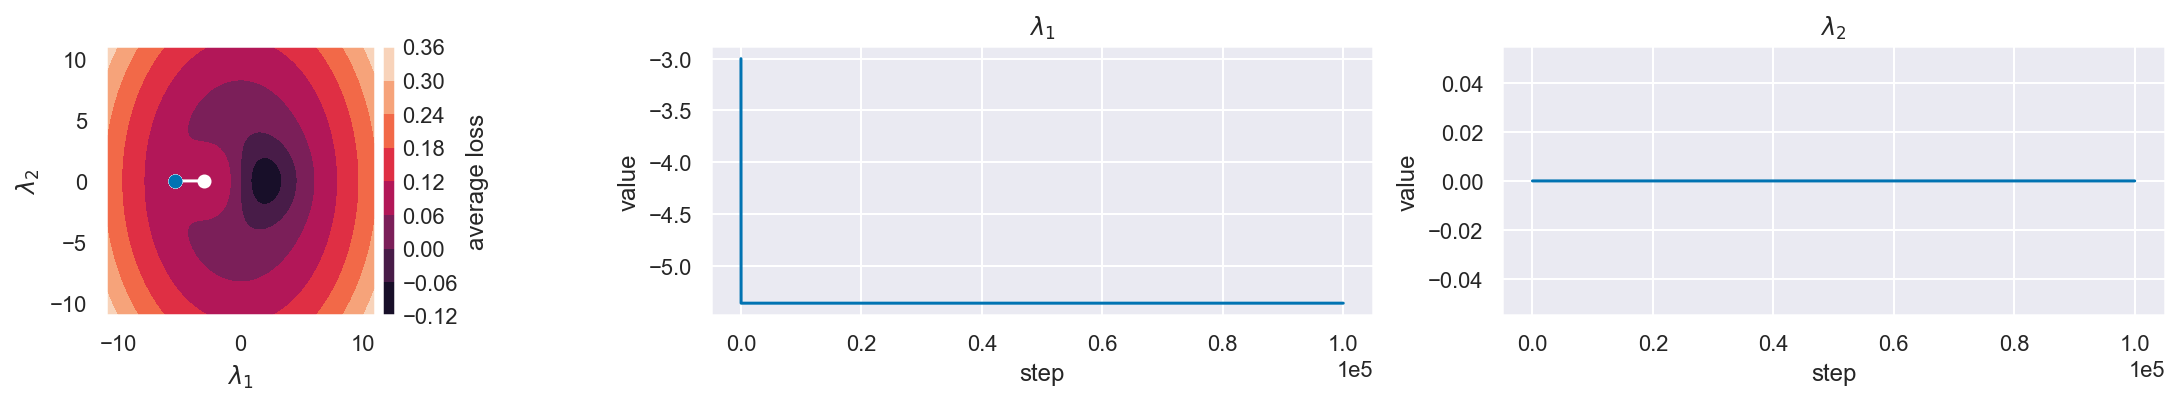


GD did not converge after 100000 steps
learning rate: 50.0
starting location: (-5, 0)
average iteration time (ms): -0.038
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


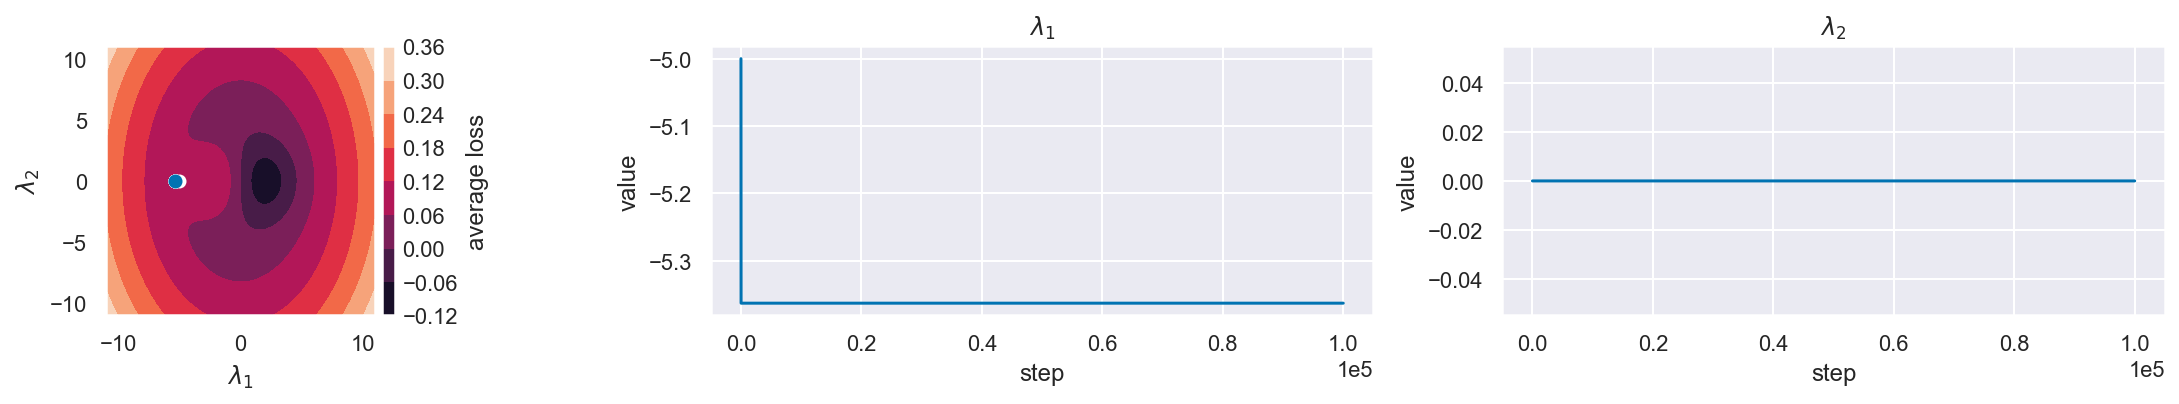


GD did not converge after 100000 steps
learning rate: 50.0
starting location: (-10, 0)
average iteration time (ms): 0.012
total number of steps: 100001
(lambda1, lambda2): [-5.36324926  0.        ]


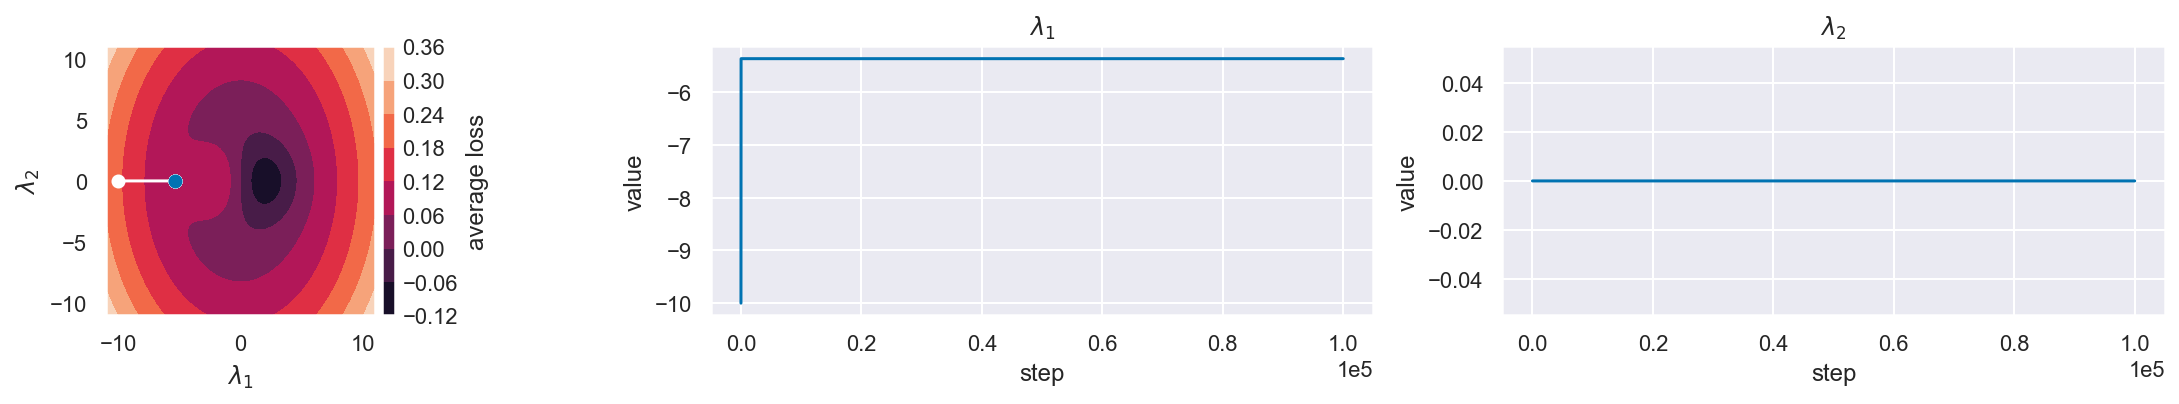


SGD results
-----------
SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 10.0
starting location: (-2.47865, 0)
average iteration time (ms): 0.013
total number of steps: 160002
(lambda1, lambda2): [-2.47864625  0.        ]


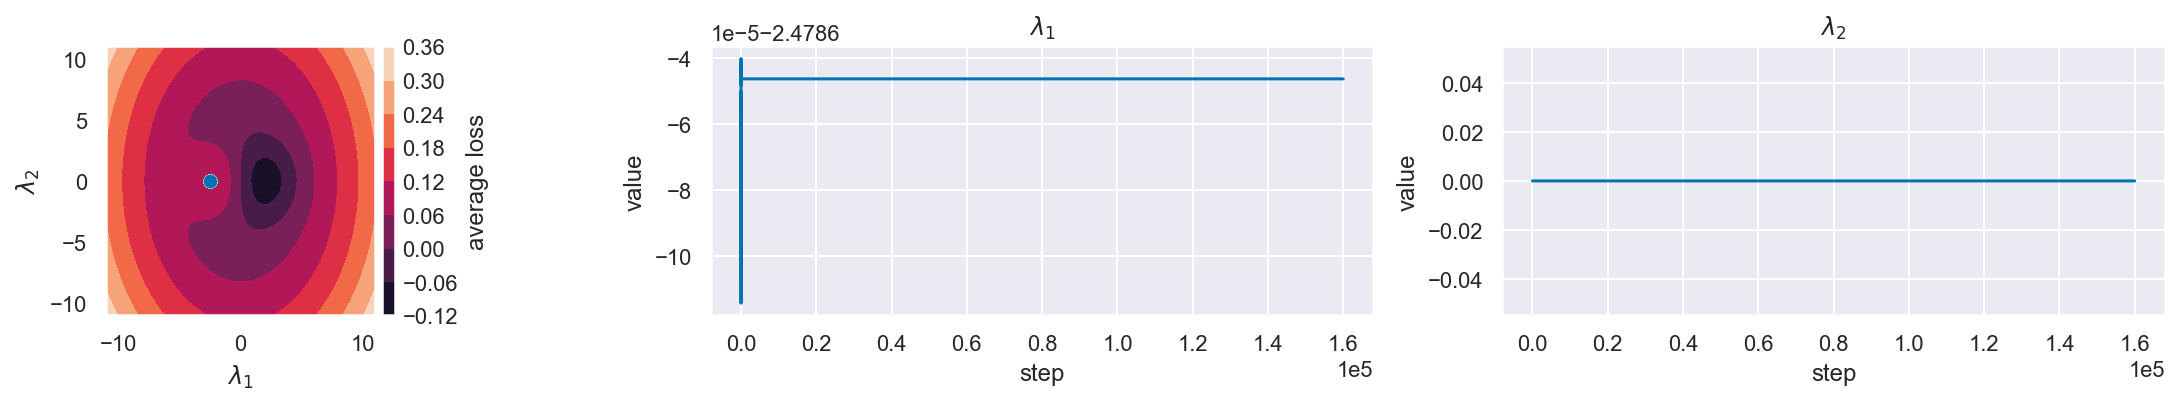


SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 10.0
starting location: (-3, 0)
average iteration time (ms): 0.012
total number of steps: 160002
(lambda1, lambda2): [-2.47864625  0.        ]


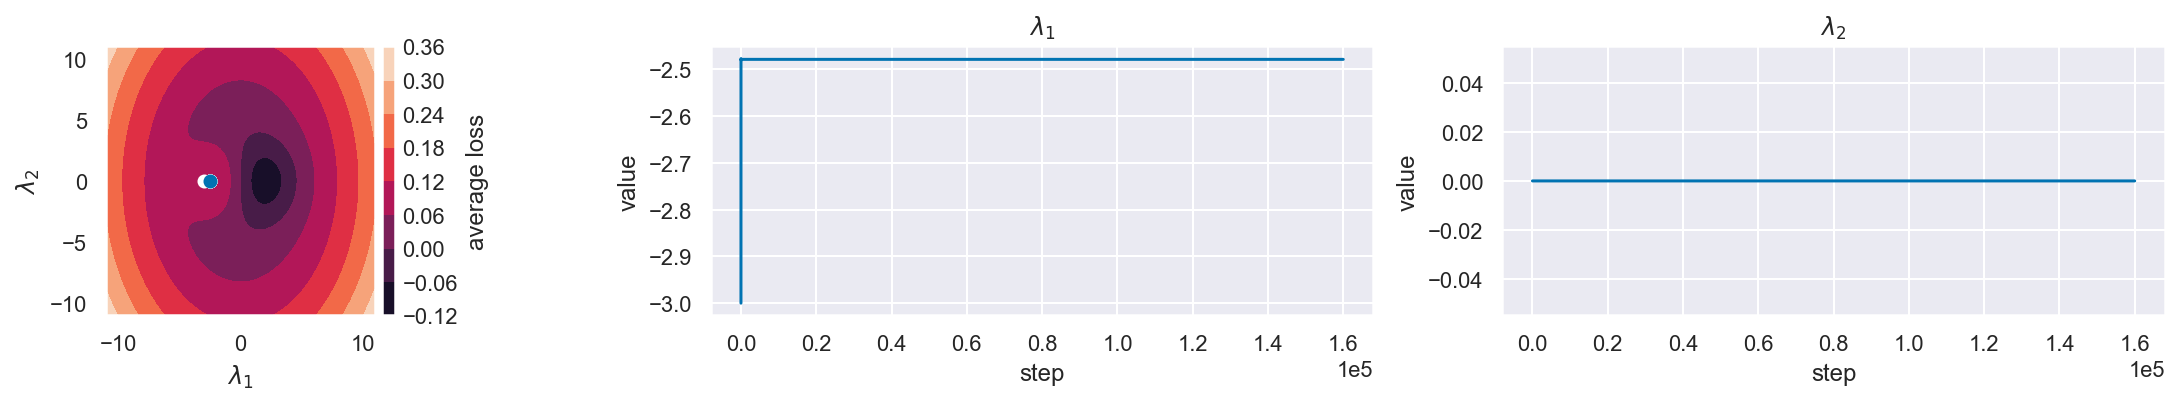


SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 10.0
starting location: (-5, 0)
average iteration time (ms): 0.013
total number of steps: 160002
(lambda1, lambda2): [-5.36324926  0.        ]


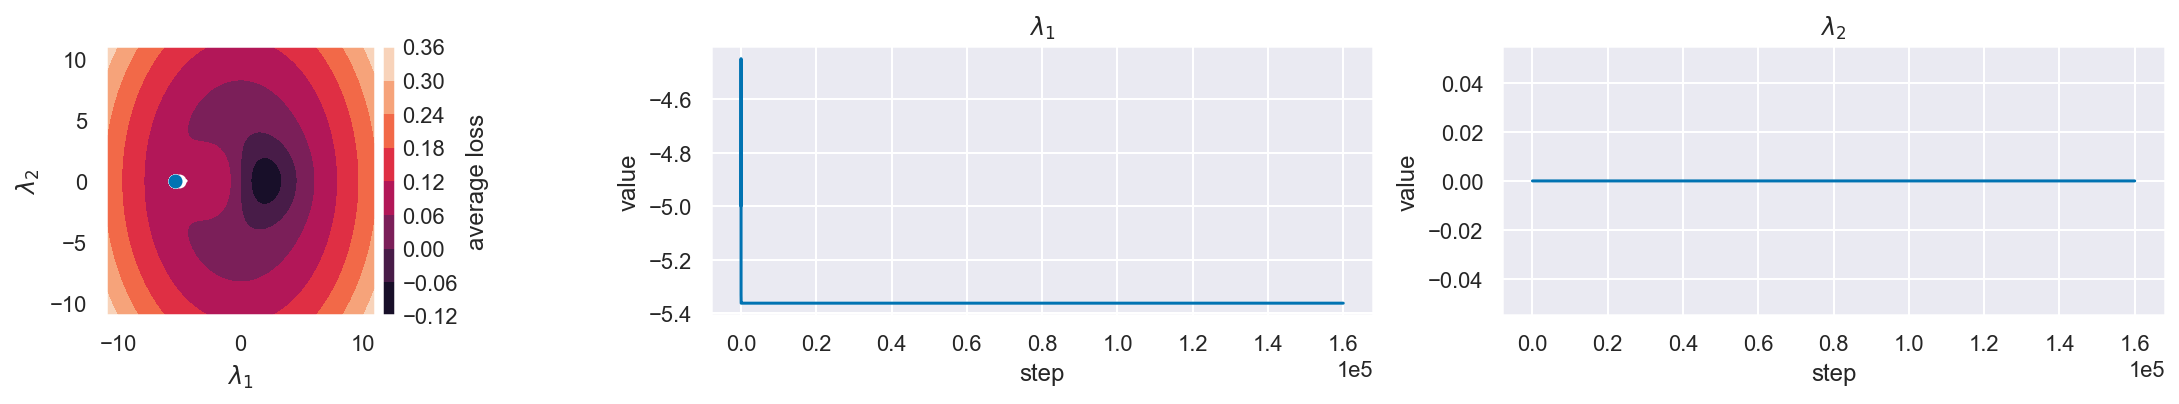


SGD did not converge after 160000 total steps within 10 epoch(s)
learning rate: 10.0
starting location: (-10, 0)
average iteration time (ms): 0.012
total number of steps: 160002
(lambda1, lambda2): [-5.36324926  0.        ]


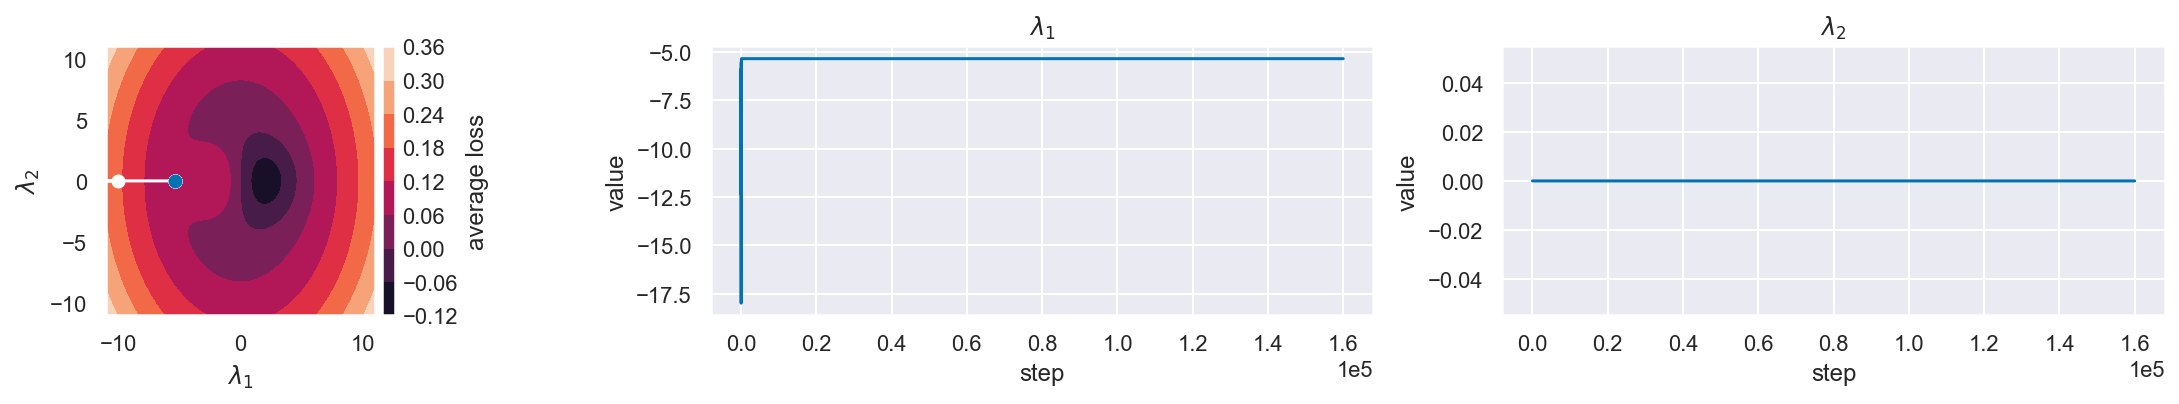


SGD converged after 28413 total steps within 2 epoch(s)
learning rate: 50.0
starting location: (-2.47865, 0)
average iteration time (ms): 0.012
total number of steps: 28415
(lambda1, lambda2): [2.053333 0.      ]


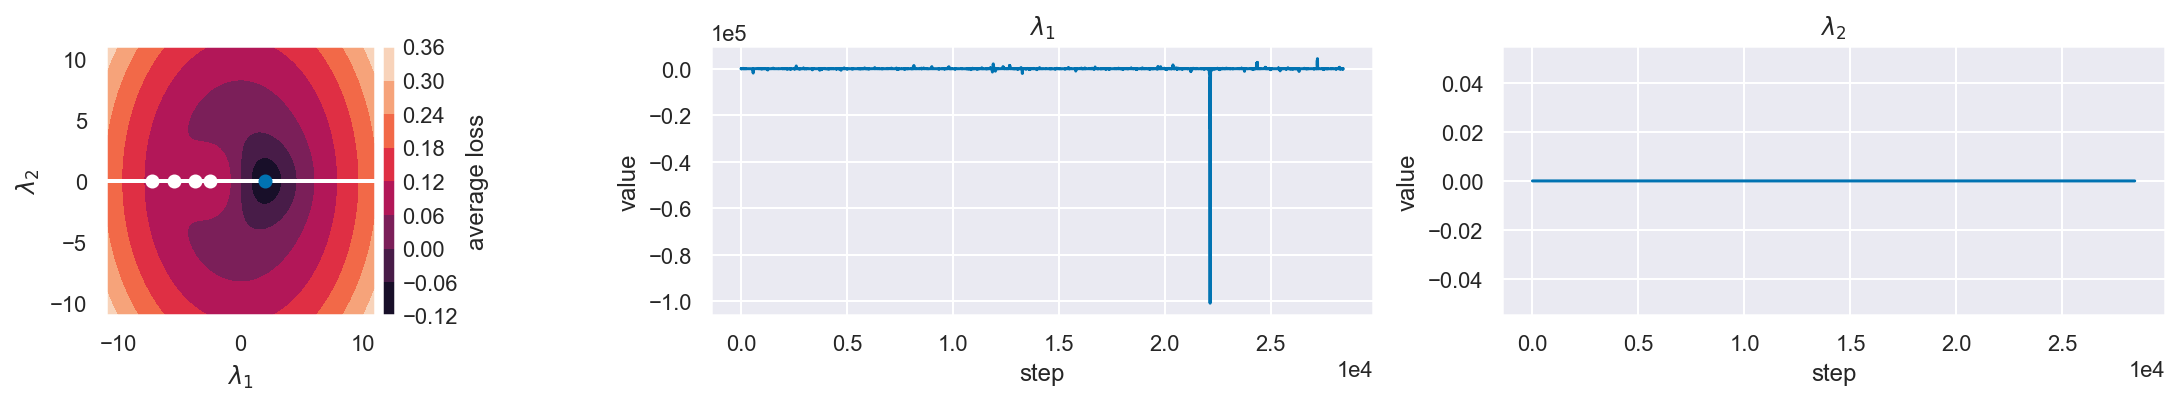


SGD converged after 2450 total steps within 1 epoch(s)
learning rate: 50.0
starting location: (-3, 0)
average iteration time (ms): 0.012
total number of steps: 2452
(lambda1, lambda2): [2.05452201 0.        ]


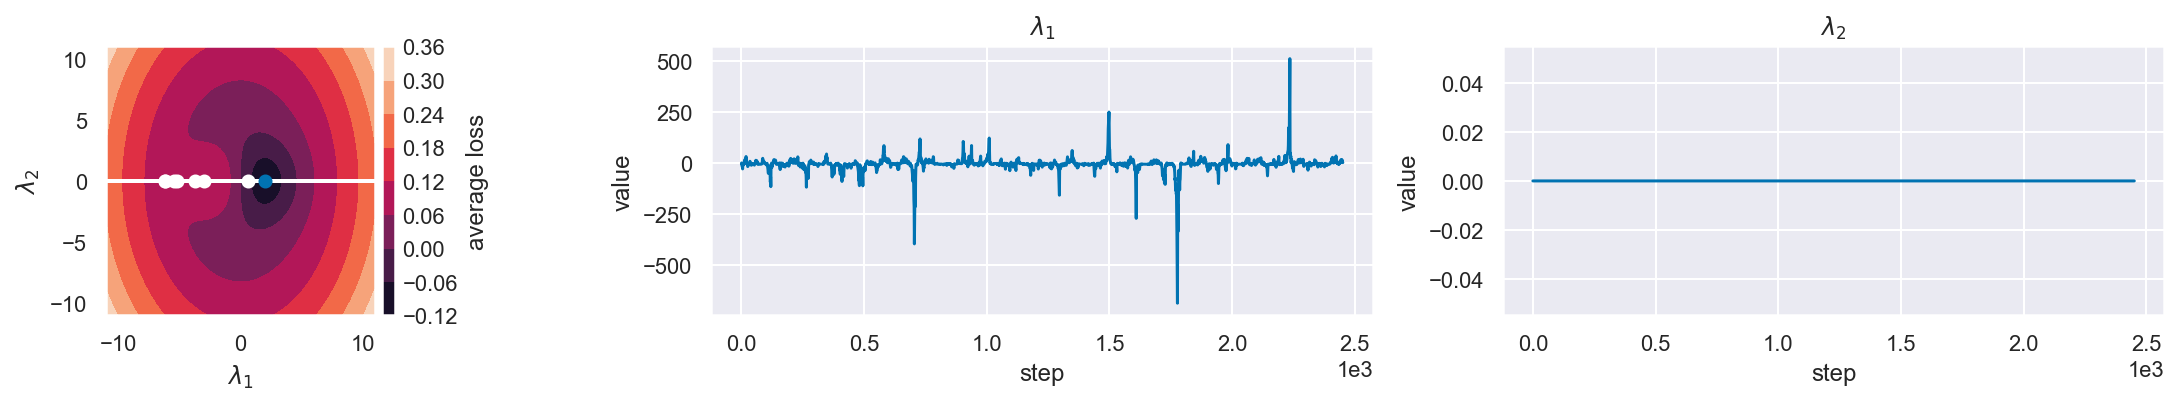


SGD converged after 1565 total steps within 1 epoch(s)
learning rate: 50.0
starting location: (-5, 0)
average iteration time (ms): 0.012
total number of steps: 1567
(lambda1, lambda2): [2.05339873 0.        ]


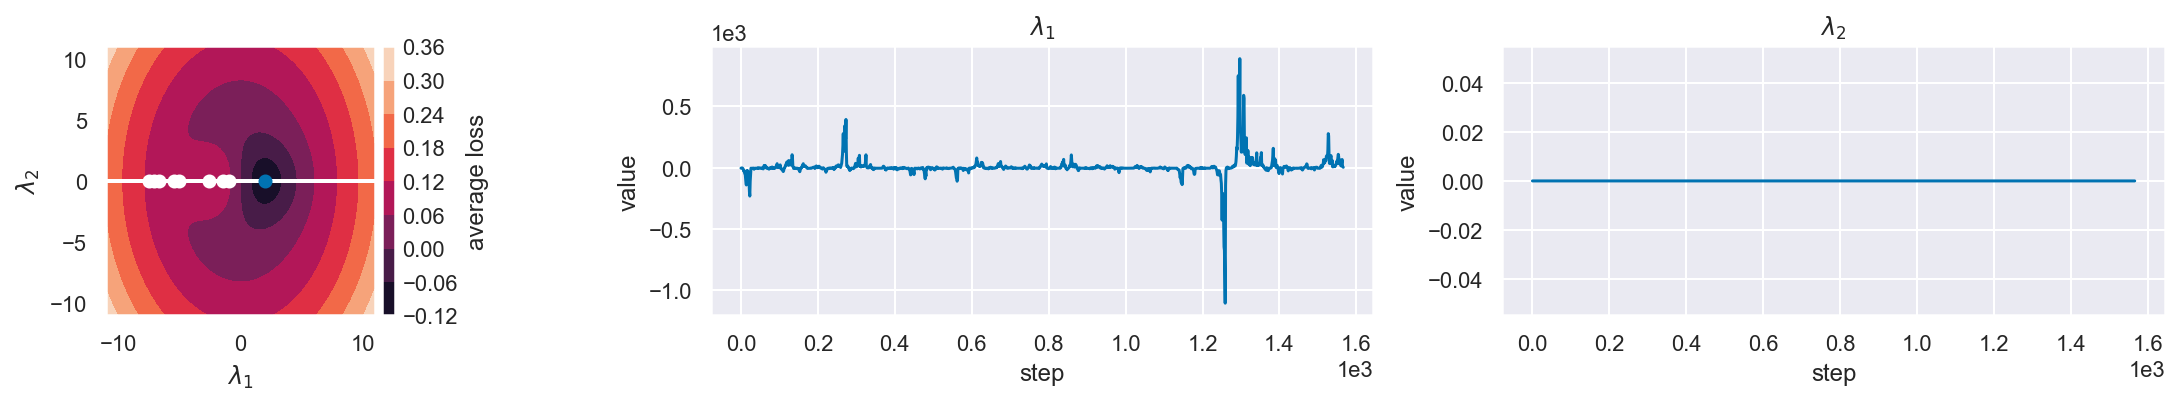


SGD converged after 706 total steps within 1 epoch(s)
learning rate: 50.0
starting location: (-10, 0)
average iteration time (ms): 0.013
total number of steps: 708
(lambda1, lambda2): [2.0545589 0.       ]


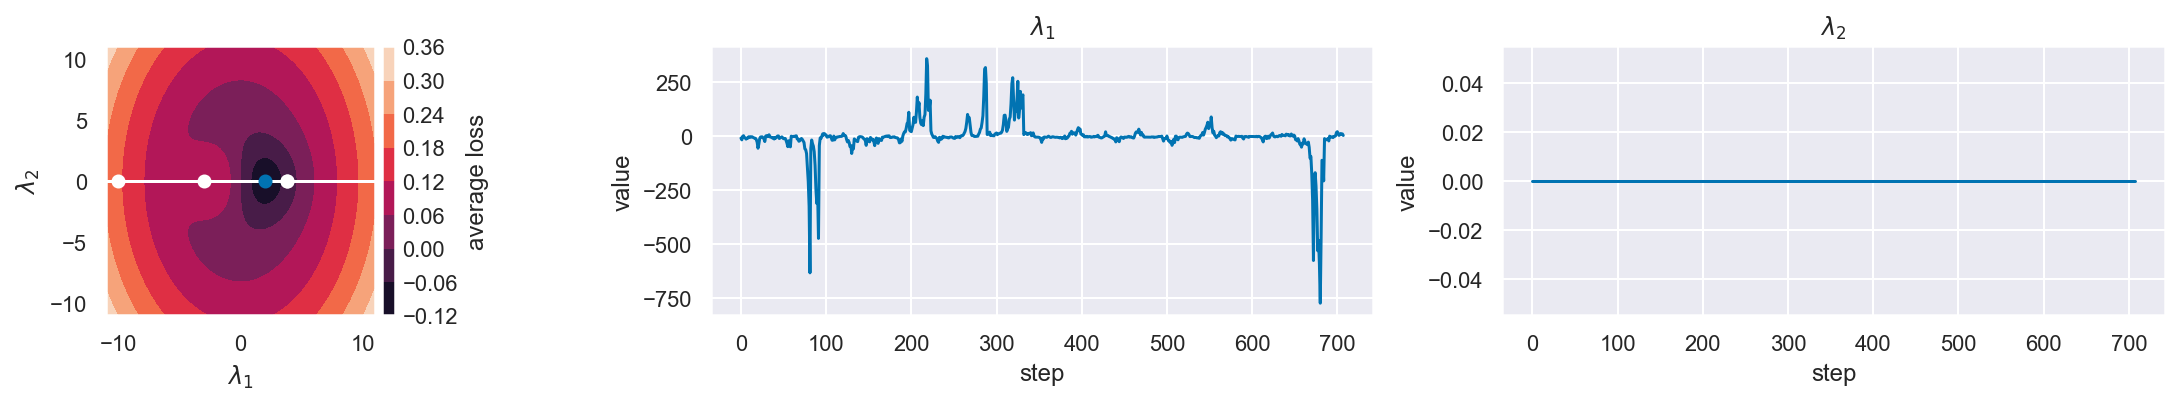

In [9]:
data = np.loadtxt("HW5_data.csv", delimiter=',')
GD_params = {
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "max_iters": 1e5, # GD terminates if this limit is met
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats":False
}
SGD_params = {
    "tol": 1e-3, # convergence tolerance for normed distance to truth values  
    "N": 1e6, # size of pre-allocated array to hold all lambda estimates
    "max_epochs": 10, # GD terminates if this limit is met
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "grad": grad_net_avg, # gradient function
    "data": data, # input data
    "show_stats": False,
    "bs": 1, # batch size
}

learning_rates = [10., 50.]

inits = (
    (-2.47865, 0),
    (-3, 0),
    (-5, 0),
    (-10, 0),
)

print("GD results")
print("----------")
for lr in learning_rates:
    for init in inits:
        lambdas_GD, times_GD = GD(**GD_params, lr=lr, init=init)
        t_avg, N = np.mean(times_GD * 1e3), len(lambdas_GD)
        print(f"learning rate: {lr}")
        print(f"starting location: {init}")
        print(f"average iteration time (ms): {t_avg:.3f}")
        print(f"total number of steps: {N}")
        print(f"(lambda1, lambda2): {lambdas_GD[-1, :]}")
        plot_descent(lambdas_GD, init, 
                 loss_func_avg, data, label="average loss")
        print()

print("SGD results")
print("-----------")
for lr in learning_rates:
    for init in inits:
        lambdas_SGD, times_SGD = SGD(**SGD_params, lr=lr, init=init)
        t_avg, N = np.mean(times_SGD * 1e3), len(lambdas_SGD)
        print(f"learning rate: {lr}")
        print(f"starting location: {init}")
        print(f"average iteration time (ms): {t_avg:.3f}")
        print(f"total number of steps: {N}")
        print(f"(lambda1, lambda2): {lambdas_SGD[-1, :]}")
        plot_descent(lambdas_SGD, init, 
                 loss_func_avg, data, label="average loss")
        print()

We see that no matter the learning rate, GD has no chance of converging if we start on the wrong side of the hill, since it will keep following the downhill on the side of the maxima AWAY from the global minimum. SGD on the other hand is able to overcome this issue for multiple learning rates because it has the ability to randomly hop off the wrong side of the hill and approach the global minimum. This as the unwanted side-effect of being succeptible to outliers though.

### Part II: Simulated Annealing
1. Implement Simulated Annealing initialized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

  For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should feel free to set your own):

  - Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
  - Min Length: 500
  - Max Temperature: 10

  You should set your own cooling schedule.

#### 2.1 Simulated Annealing Implementation

In Simulated Annealing, instead of going down the steepest path like in GD (which we saw can fail if we start on the wrong side of the "hill"), or picking random points to define our downhill path like in SGD (which can take many steps to converge), we will leverage the information stored in our neighbors. The basic idea is the following:

1. start somewhere in our parameter space
2. propose a new location to hop to
3. if the proposed location has a lower loss value, go there
4. if it doesn't, still hop there if $e^{-\Delta E / T} \ge Unif[0, 1]$, where $\Delta E = L(\text{proposed location}) - L(\text{current location})$, and $T$ is some constant
5. otherwise, stay in place and go back to step 2

The idea is that the algorithm will consistently accept "good moves" towards the global minimum while still probabilistically accepting "bad moves" that help us escape local minima as well as downhills on the wrong side of the mountain that we may get stuck on. The constant $T$ is also "cooled down" each step so that as we near the global minimum, we take finer and finer steps.

Using a power law cooling schedule $T = T_\text{max} \times \eta^\text{step number}$ (courtesy of the lecture slides) produces the following results:

SA did not converge after 1000 steps
(lambda1, lambda2): [ 2.05710127 -0.03958061]
starting location: [-5.  1.]
average iteration time (ms): 1.187


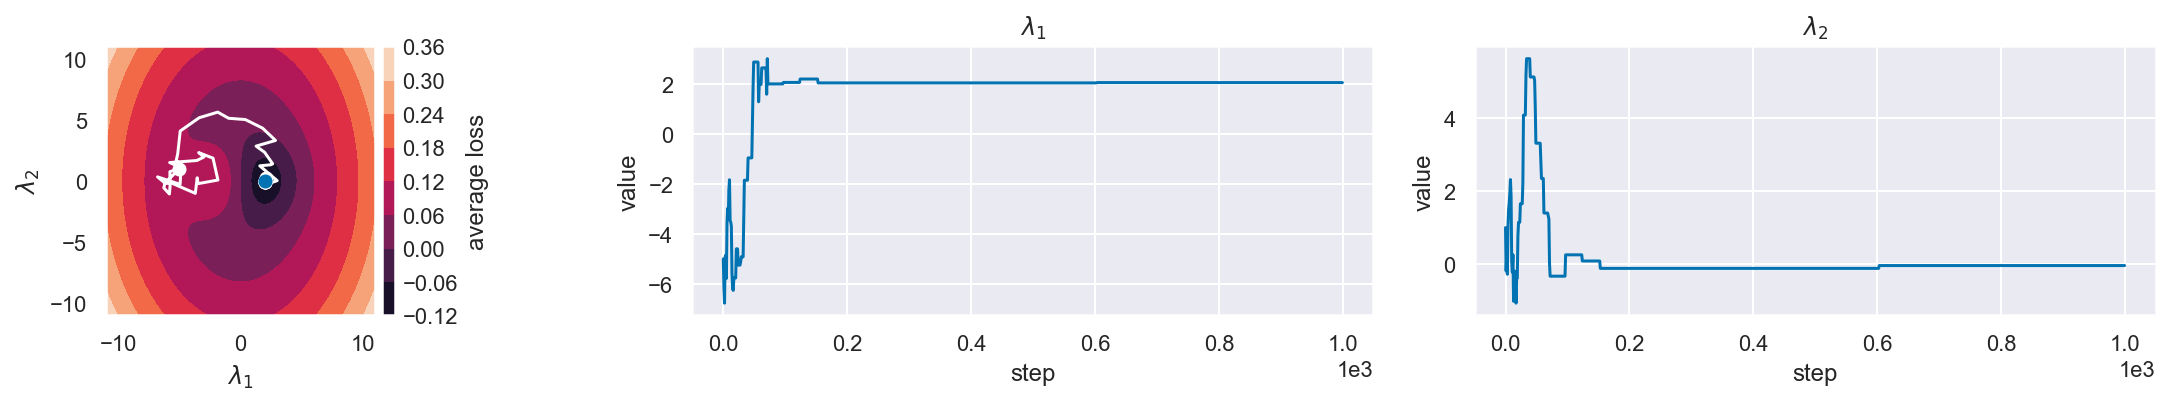

In [10]:
# simulated annealing algorithm
def SA(init=_, truth=_, tol=_, Tmax=_, loss_func=_, data=_, max_iters=_, 
       proposal=_, cool_T=_):
    max_iters = int(max_iters)
    times = np.ones(max_iters)
    sols = np.ones((max_iters, 2)) * -1 # easier to flag un-filled slots
    sols[0, :] = init
    T = Tmax
    n = 1
    for n in range(1, max_iters):
        start = time.perf_counter()
        prop = proposal(sols[n-1, :])
        delta_E = loss_func(*prop, *data) - loss_func(*sols[n-1, :], *data)
        if delta_E < 0: 
            sols[n, :] = prop
        else:
            U = np.random.uniform()
            alpha = np.min([1., np.exp(-delta_E / T)])
            if alpha >= U:
                sols[n, :] = prop
            else:
                sols[n, :] = sols[n-1, :]
            
        T = cool_T(T)  # cool down
        end = time.perf_counter() - start
        times[n-1] = end   
        
        # check for convergence
        diff = np.sqrt(np.sum((sols[n, :] - truth)**2)) # norm distance
        if diff <= tol:
            print(f"SA converged after {n} steps")
            n += 1
            break 

        # go to next step
        n += 1
        
    # if convergence is not met, still run to end and report results
    if diff > tol:
        print(f"SA did not converge after {n} steps")
    
    return sols[:n, :], times[:n]

# run SA
data = np.loadtxt("HW5_data.csv", delimiter=',')
s = 1 # variance on (lambda_1, lambda_2) proposal
SA_params = {
    "init": np.array([-5., 1.]), # starting location
    "truth": np.array([2.05384, 0.]), # (lambda_1, lambda_2) true value
    "tol": np.finfo(float).eps, # convergence tolerance for normed distance to truth values
    "Tmax": 1., # starting temperature
    "loss_func": loss_func_avg, # loss function to minimize over
    "data": data, # data loss function is evaluated on  
    "max_iters": 1e3, 
    "proposal": lambda mean, cov=1: np.random.multivariate_normal(mean, cov=[[1,0],[0, 1]]),
    "cool_T": lambda T: T*0.7
}
lambdas_SA, times_SA = SA(**SA_params)

# display results
print(f"(lambda1, lambda2): {lambdas_SA[-1, :]}")
print(f"starting location: {SA_params['init']}")
t_avg = np.mean(times_SA * 1e3)
print(f"average iteration time (ms): {t_avg:.3f}")
plot_descent(lambdas_SA, SA_params["init"], loss_func_avg, data, 
             label="average loss")

Here we see that SA does not converge to within 1e-3 of the "true" values for $(\lambda_1, \lambda_2)$, but it does get close and stays there indefinitely. This is thanks to the cooling schedule. It is a double edged sword though because while it helps keep us near the global minimum, it also makes it hard to continue exploring near that region as the temperature continues to cool.

Compared to SGD, it "converges" faster and overcomes the problem with SG never being able to converge if we start on the wrong side of the hill.